1. load the scenario

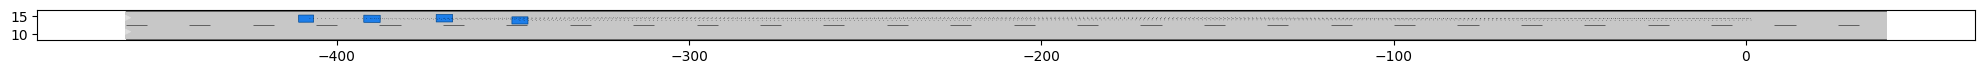

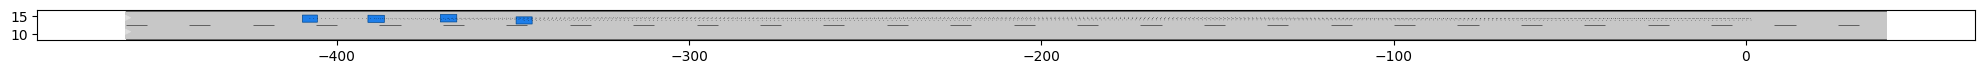

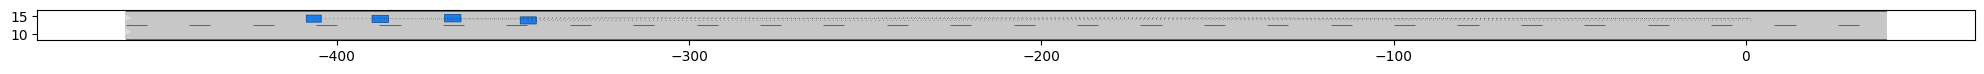

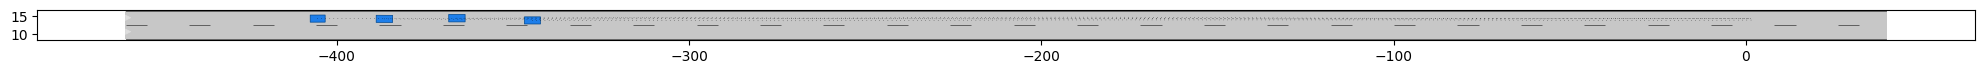

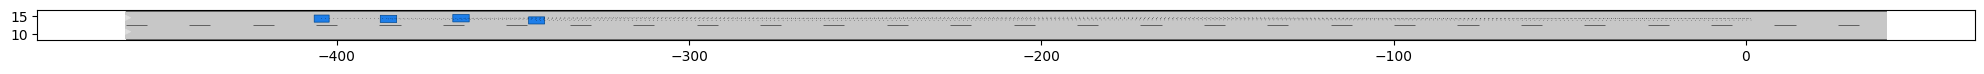

In [140]:
%matplotlib inline
import os
import scipy
from sre_parse import State
from turtle import position
import numpy as np
import pkg_resources
from cvxpy import *
import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad.visualization.draw_params import DynamicObstacleParams


file_path = os.path.join(os.getcwd(), 'highD_01_T_1201-1800.xml')
# file_path = os.path.join(os.getcwd(), 'kernel_regression-1_0.xml') #   kernel_regression-1_0
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

for obs in scenario.obstacles:
    if obs.obstacle_id < 10067 or obs.obstacle_id > 10070: # or obs.obstacle_id == 10066:
        # print(obs.obstacle_id)
        scenario.remove_obstacle(obs)

# scenario.remove_obstacle([scenario.obstacles[0],scenario.obstacles[1]])
translation = np.array([0.0, 0.0])
angle = np.pi

scenario.translate_rotate(translation, angle)
planning_problem_set.translate_rotate(translation, angle)

frame = 1342
for i in range(frame,frame+5):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    rnd.draw_params.time_end = 1800
    scenario.draw(rnd)
    rnd.render()

In [141]:
from cProfile import label

path = 'D:\\learn\\23SS\\guided_research\\RL\\commonroad_io\\tutorials\\data_inter\\'  #os.path.abspath(os.path.dirname(__file__))
x_data = np.load(path + 'x_cur.npy')
matlab_data = scipy.io.loadmat(path + 'solution.mat')
solution_quad = scipy.io.loadmat(path + 'solution_quad.mat')
sol = matlab_data['x']
N_data = int((len(sol) - 1) / 2)
alphas = sol[:N_data]
alphas_quad = solution_quad['x_quad'][:3]


class Parameters:
    beta = 0.2
    dt = 0.04
    h = 0.913008
    A = np.array([[1, dt], [0, 1]])
    B = np.array([-dt * (h + dt), -dt])


# define optimal policy function
def policy_kernel(x, x_data, alphas, p: Parameters):
    sum_ = 0
    for i in range(N_data):
        sum_ += 2 * alphas[i] * x_data[i] * (1 + x_data[i] @ (p.A @ x))
    return -p.beta * sum_ @ p.B


def policy_quadratic(x, alphas_quad, p: Parameters):
    a = alphas_quad
    x_next = p.A @ x
    return -p.beta * 2 * p.B @ np.array([
        a[0] * x_next[0] + a[1] * x_next[1],
        a[1] * x_next[0] + a[2] * x_next[1]
    ])


class TIConstraints:
    a_min = -8
    a_max = 15
    s_min = 0
    s_max = 150
    v_min = 0
    v_max = 35


def plot_state(x_p, pos, vel, data_pre, data_fol, p: Parameters):
    plt.figure(figsize=(10, 10))
    N = pos.shape[0] - 1

    # Plot (x_t)_1.
    plt.subplot(4, 1, 1)
    # x1 = (x.value)[0, :].flatten() - h * (x.value)[1, :].flatten()
    plt.plot(np.array(range(N + 1)), pos, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), data_fol[:, 0], 'b', label='data')
    plt.ylabel(r"$s$", fontsize=16)
    plt.legend()
    # plt.yticks(np.linspace(c.s_min, s_max, 3))
    # plt.ylim([c.s_min, s_max])
    plt.xticks([])

    # Plot (x_t)_2.
    plt.subplot(4, 1, 2)
    plt.plot(np.array(range(N + 1)), vel, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), data_fol[:, 1], 'b', label='data')
    plt.ylabel(r"$v$", fontsize=16)
    plt.legend()
    plt.xticks([])

    # Plot (x_t)_3.
    plt.subplot(4, 1, 3)
    x1 = x_p[:, 0] - pos - p.h * vel
    x1_data = data_pre[:, 0] - data_fol[:, 0] - p.h * data_fol[:, 1]
    plt.plot(np.array(range(N + 1)), x1, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), x1_data, 'b', label='data')
    plt.legend()
    plt.ylabel(r"$x1$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_4.
    plt.subplot(4, 1, 4)
    x2 = x_p[:, 1] - vel
    x2_data = data_pre[:, 1] - data_fol[:, 1]
    plt.plot(np.array(range(N + 1)), x2, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), x2_data, 'b', label='data')
    plt.legend()
    plt.ylabel(r"$x2$", fontsize=16)
    plt.xticks([])
    plt.xticks(np.arange(0, N + 1, 20))
    plt.xlabel(r"$k$", fontsize=16)
    plt.tight_layout()
    plt.show()

In [142]:
# problem data
N_vehicles = len(scenario.obstacles)
# N = 100  # number of time steps
n = 2  # length of state vector
m = 1  # length of input vector
dt = scenario.dt  # time step

# set up constraints
c = TIConstraints()
c.a_min = -6  # Minimum feasible acceleration of vehicle
c.a_max = 6  # Maximum feasible acceleration of vehicle
c.s_min = 0  # Minimum allowed position
c.s_max = 130  # Maximum allowed position
c.v_min = 0  # Minimum allowed velocity
c.v_max = 35  # Maximum allowed velocity (speed limit)

# set up system parameters
p = Parameters()

# weights for cost function
w_s = 0.0008
w_v = 0.9882  #0.9882
Q = np.eye(n) * np.transpose(np.array([w_s, w_v]))
w_u = 2.5
R = w_u
p.beta = 0.5 / R

# terms of system dynamic
p.h = 0.913008
p.A = np.array([[1, dt], [0, 1]])
p.B = np.array([-dt * (p.h + dt), -dt])

In [143]:
initial_frame = scenario.obstacles[-1].prediction.initial_time_step
end_frame = scenario.obstacles[0].prediction.final_time_step
N_frames = end_frame - initial_frame
N = int(N_frames)
print(N_frames)

initial_states = np.zeros((N_vehicles, 3))
for i in range(len(scenario.obstacles)):
    obs = scenario.obstacles[i]
    initial_states[i, 0] = obs.state_at_time(initial_frame).position[0]
    initial_states[i, 1] = obs.state_at_time(initial_frame).position[1]
    initial_states[i, 2] = obs.state_at_time(initial_frame).velocity

states_data = []
for obs in scenario.obstacles:
    states_obs = np.zeros((N + 1, 2))
    for ii in range(N + 1):
        states_obs[ii, 0] = obs.state_at_time(initial_frame + ii).position[0]
        states_obs[ii, 1] = obs.state_at_time(initial_frame + ii).velocity
    states_data.append(states_obs)

print(len(states_data))

292
4


In [144]:
for obs in scenario.obstacles:
    if obs.obstacle_id != 10067:
        # print(obs.obstacle_id)
        scenario.remove_obstacle(obs)

vehicle pair i

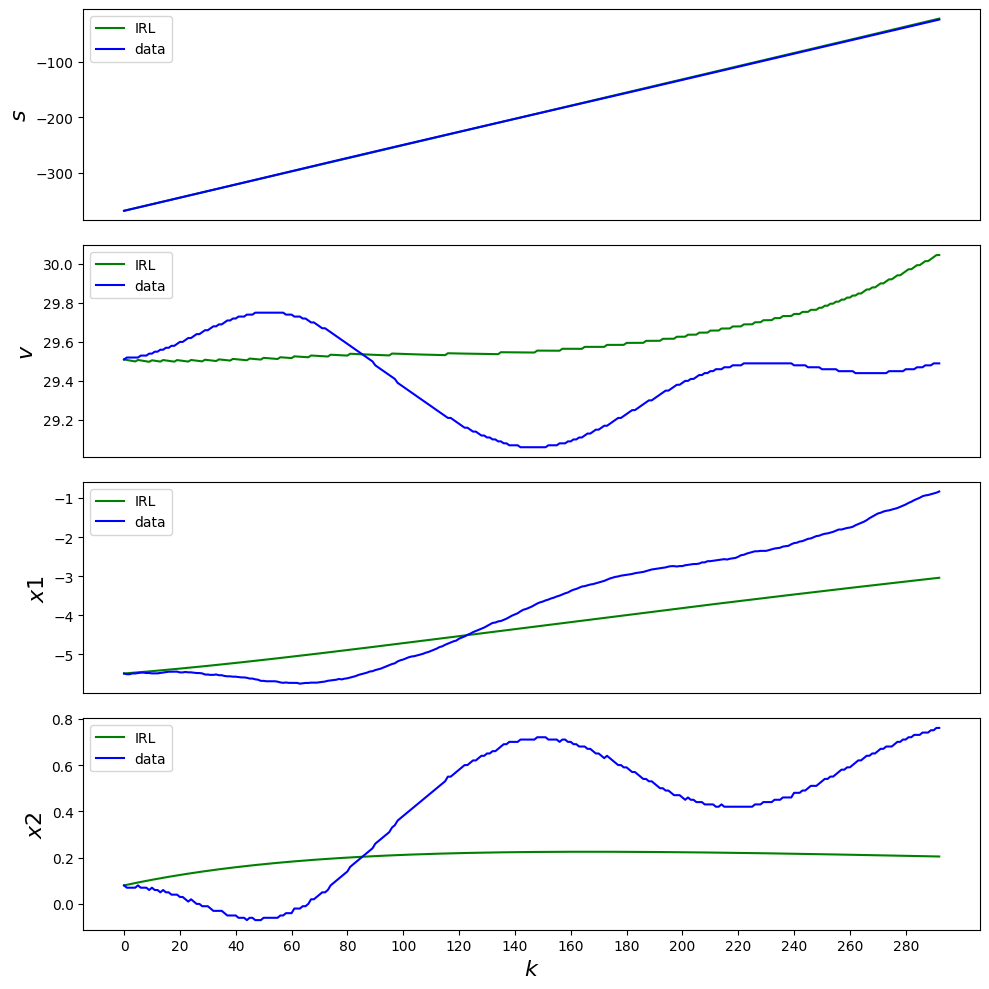

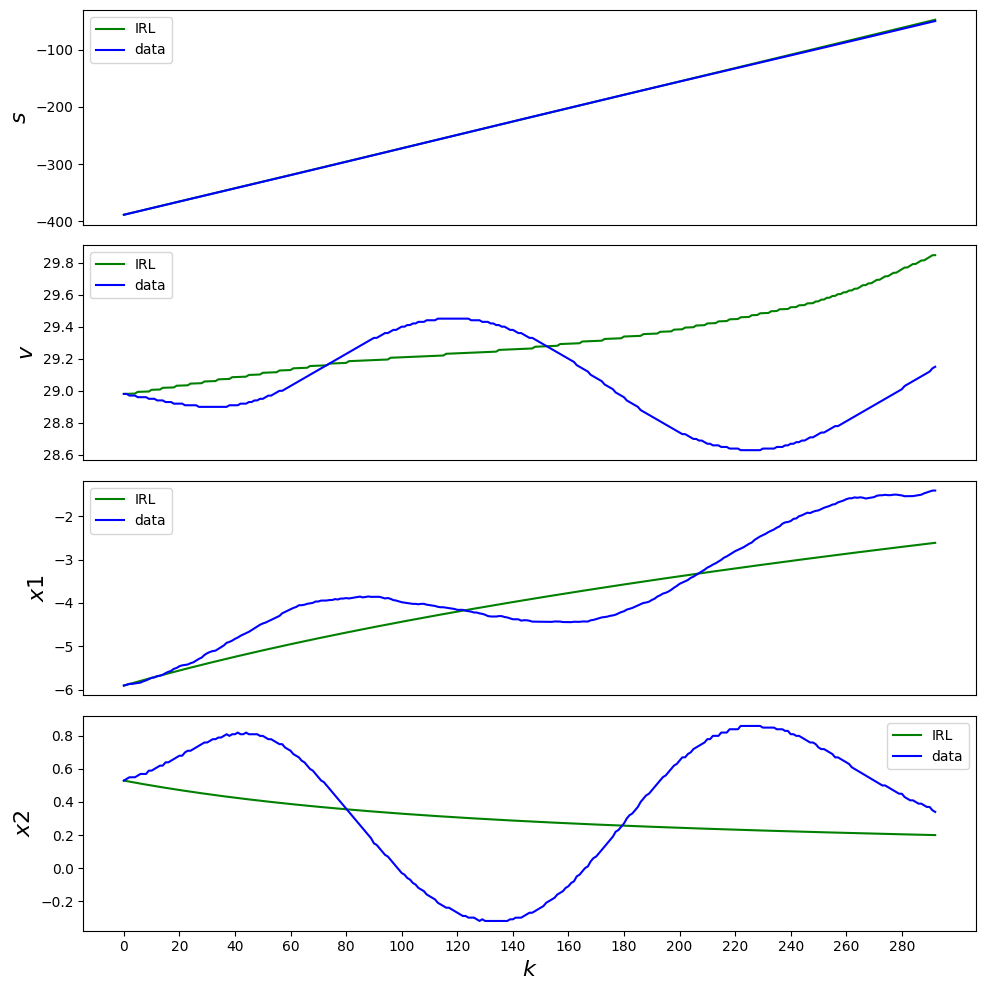

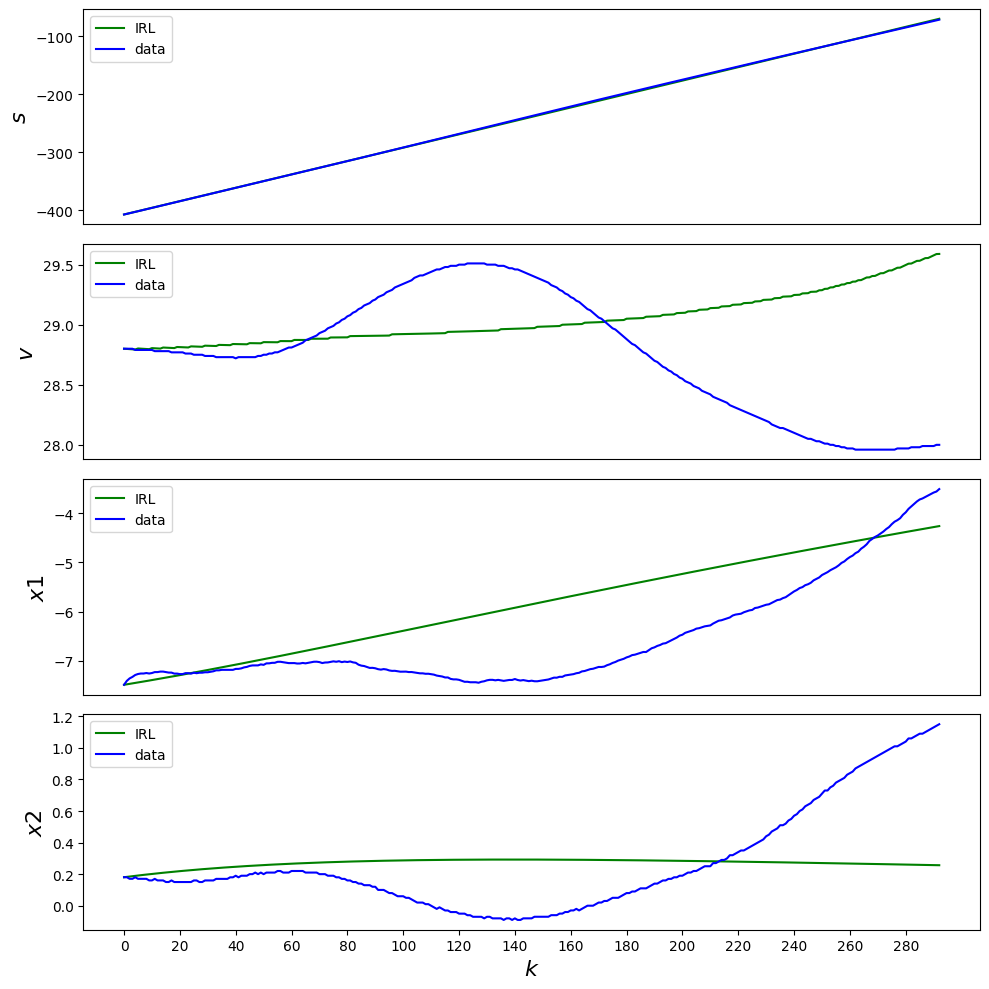

In [145]:
# import necessary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import ObstacleType, DynamicObstacle
from commonroad.scenario.state import InitialState, CustomState
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction

for i in range(N_vehicles - 1):
    vehicle_pre = scenario.obstacles[i]
    x_pre = np.zeros((N + 1, 2))
    for ii in range(N + 1):
        x_pre[ii,
              0] = vehicle_pre.state_at_time(initial_frame + ii).position[0]
        x_pre[ii, 1] = vehicle_pre.state_at_time(initial_frame + ii).velocity
    # print(x_pre[0])

    initial_position = initial_states[i + 1, 0]
    initial_velocity = initial_states[i + 1, 2]

    x_ego_initial = np.array(
        [initial_position + p.h * initial_velocity, initial_velocity])
    # print(x_ego_initial)

    x_initial = x_pre[0, :] - x_ego_initial
    # print(x_initial)

    x = np.zeros((N + 1, 2))
    u = np.zeros(N + 1)
    x[0, :] = x_initial
    vf_weight = 1
    kernel = 1
    u[0] = vf_weight * (policy_kernel(x_initial, x_data, alphas, p) if kernel
                        else policy_quadratic(x_initial, alphas_quad, p))
    # u[0] = vf_weight * (policy_quadratic(x_initial, alphas_quad, p) if kernel )

    for ii in range(N):
        x[ii + 1, :] = p.A @ x[ii, :] + p.B * u[ii]
        u[ii + 1] = vf_weight * (policy_kernel(x[ii + 1, :], x_data, alphas, p)
                                 if kernel else policy_quadratic(
                                     x[ii + 1, :], alphas_quad, p))
        # u[ii + 1] = vf_weight * policy_quadratic(x[ii + 1, :], alphas_quad, p)

    vel = x_pre[:, 1] - x[:, 1]
    pos = x_pre[:, 0] - x[:, 0] - p.h * vel
    # print(x)
    # print(u[:5])
    # print(pos[:5])

    # plot_state_vector(x, TIConstraints(), x_p=x_pre, p=pos, v=vel)
    plot_state(x_pre, pos, vel, states_data[i], states_data[i + 1], p)
    ###################

    # initial state has a time step of 0
    dynamic_obstacle_initial_state = CustomState(
        position=np.array([pos[0], initial_states[i + 1, 1]]),
        velocity=vel[0],
        orientation=0.02,
        time_step=initial_frame).convert_state_to_state(InitialState())

    # generate the states for the obstacle for time steps 1 to 40 by assuming constant velocity

    state_list = [
        CustomState(position=np.array([pos[j], initial_states[i + 1, 1]]),
                    velocity=vel[j],
                    orientation=0.02,
                    time_step=initial_frame + j) for j in range(1, N + 1)
    ]
    # print(state_list[:10])

    # create the trajectory of the obstacle, starting at time step 1
    dynamic_obstacle_trajectory = Trajectory(initial_frame + 1, state_list)

    # create the prediction using the trajectory and the shape of the obstacle
    dynamic_obstacle_shape = Rectangle(width=1.8, length=4.3)
    dynamic_obstacle_prediction = TrajectoryPrediction(
        dynamic_obstacle_trajectory, dynamic_obstacle_shape)

    # generate the dynamic obstacle according to the specification
    dynamic_obstacle_id = scenario.generate_object_id()
    dynamic_obstacle_type = ObstacleType.CAR
    dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id,
                                       dynamic_obstacle_type,
                                       dynamic_obstacle_shape,
                                       dynamic_obstacle_initial_state,
                                       dynamic_obstacle_prediction)
    ego_vehicle = dynamic_obstacle

    # plot the scenario and the ego vehicle for each time step
    ego_params = DynamicObstacleParams()
    ego_params.vehicle_shape.occupancy.shape.facecolor = "g"
    # for ii in range(initial_frame, initial_frame + 10):
    #     plt.figure(figsize=(25, 10))
    #     rnd = MPRenderer()
    #     rnd.draw_params.time_begin = ii
    #     rnd.draw_params.time_end = 1800
    #     scenario.draw(rnd)
    #     ego_params.time_begin = ii
    #     ego_params.time_end = 1800
    #     ego_vehicle.draw(rnd, draw_params=ego_params)
    #     rnd.render()

    # add dynamic obstacle to the scenario
    scenario.add_objects(ego_vehicle)


[CustomState(time_step=1), CustomState(time_step=2), CustomState(time_step=3), CustomState(time_step=4), CustomState(time_step=5), CustomState(time_step=6), CustomState(time_step=7), CustomState(time_step=8), CustomState(time_step=9), CustomState(time_step=10), CustomState(time_step=11), CustomState(time_step=12), CustomState(time_step=13), CustomState(time_step=14), CustomState(time_step=15), CustomState(time_step=16), CustomState(time_step=17), CustomState(time_step=18), CustomState(time_step=19), CustomState(time_step=20), CustomState(time_step=21), CustomState(time_step=22), CustomState(time_step=23), CustomState(time_step=24), CustomState(time_step=25), CustomState(time_step=26), CustomState(time_step=27), CustomState(time_step=28), CustomState(time_step=29), CustomState(time_step=30), CustomState(time_step=31), CustomState(time_step=32), CustomState(time_step=33), CustomState(time_step=34), CustomState(time_step=35), CustomState(time_step=36), CustomState(time_step=37), CustomSta

C:\Users\zhaox\AppData\Local\Temp\ipykernel_19540\1819390301.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(25, 10))


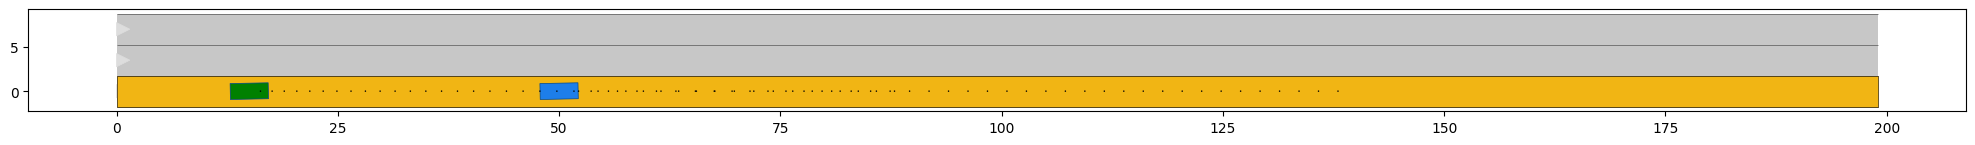

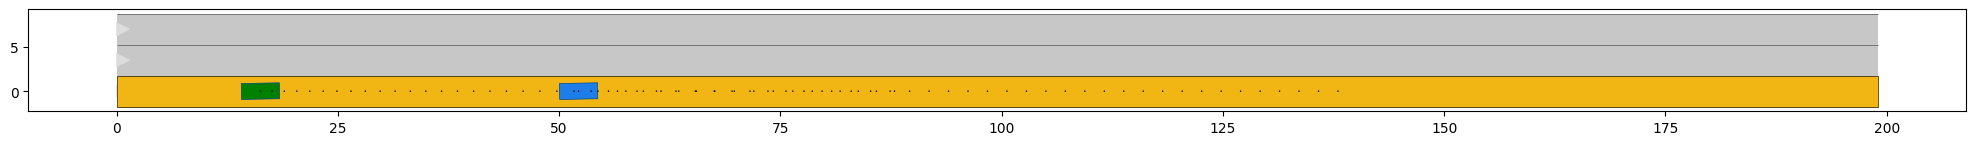

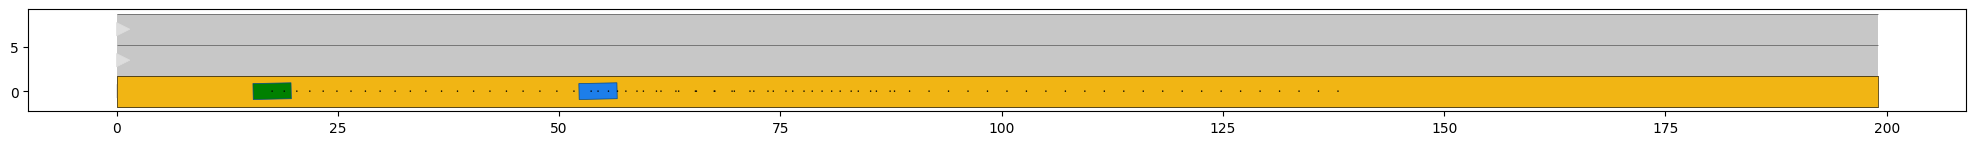

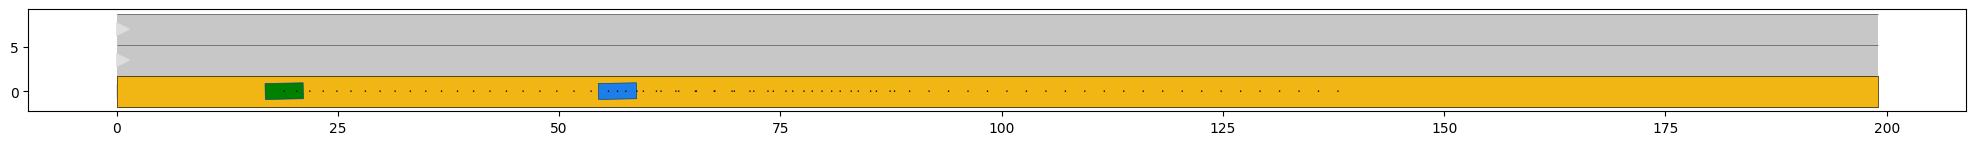

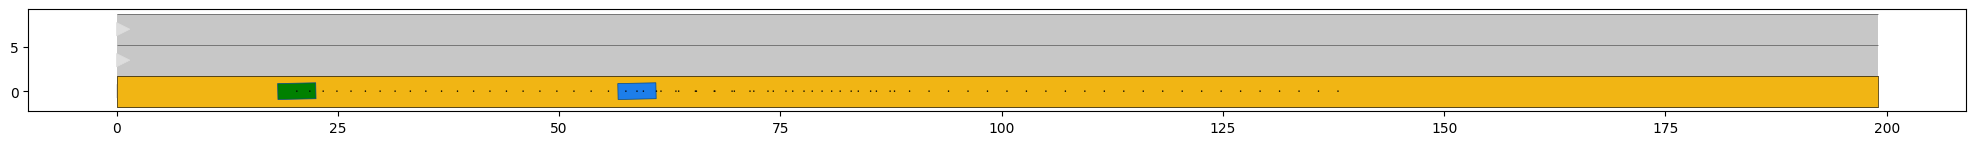

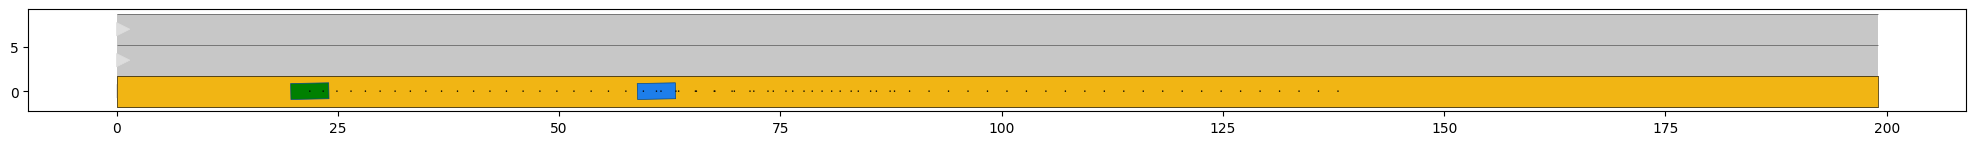

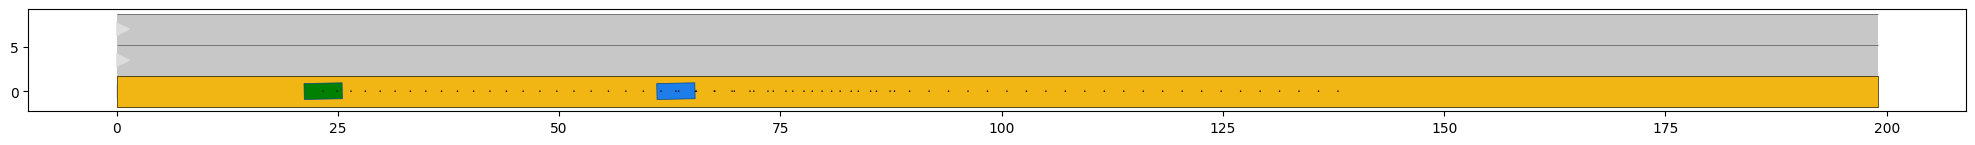

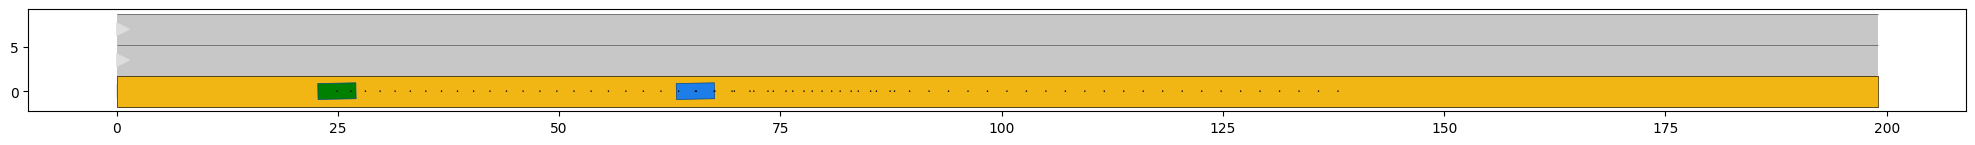

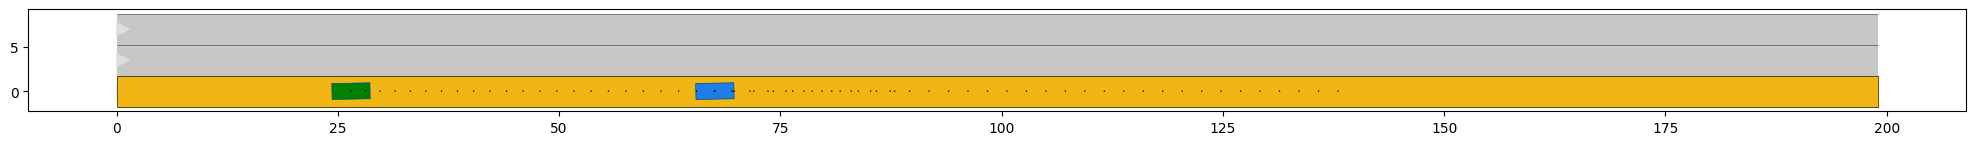

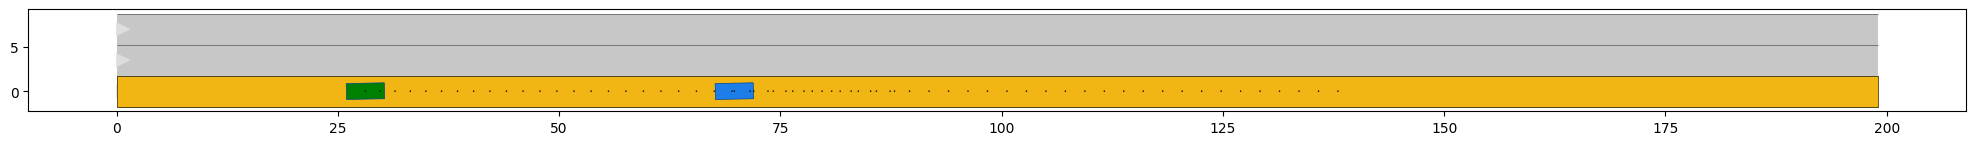

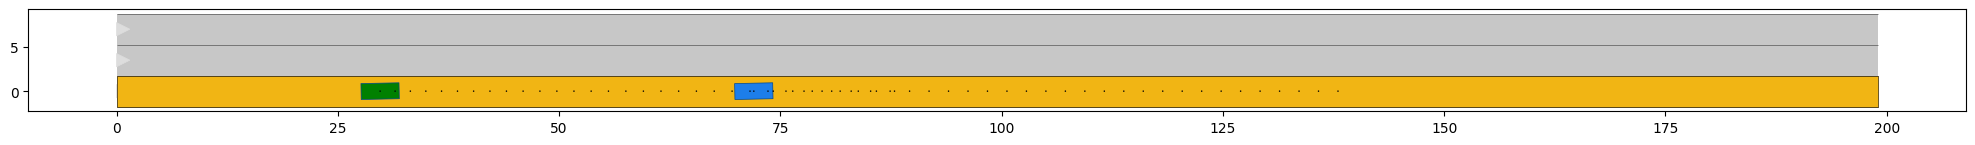

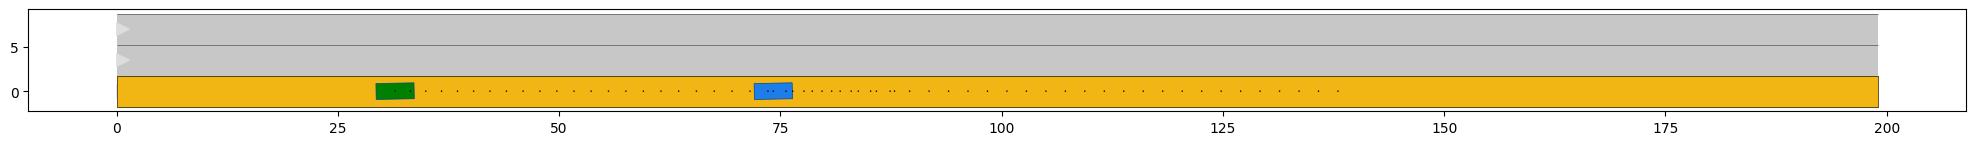

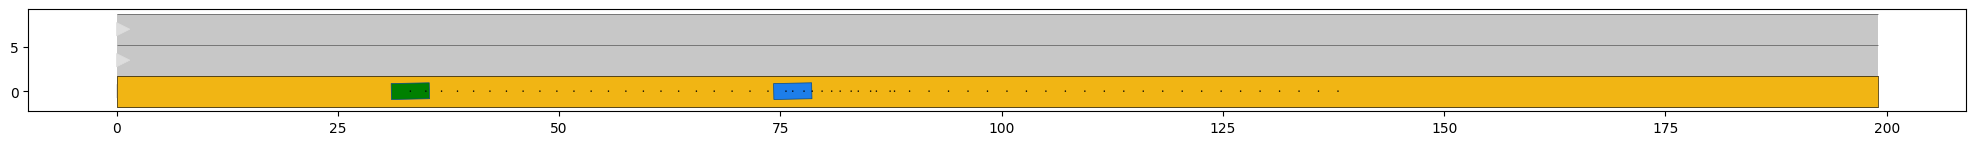

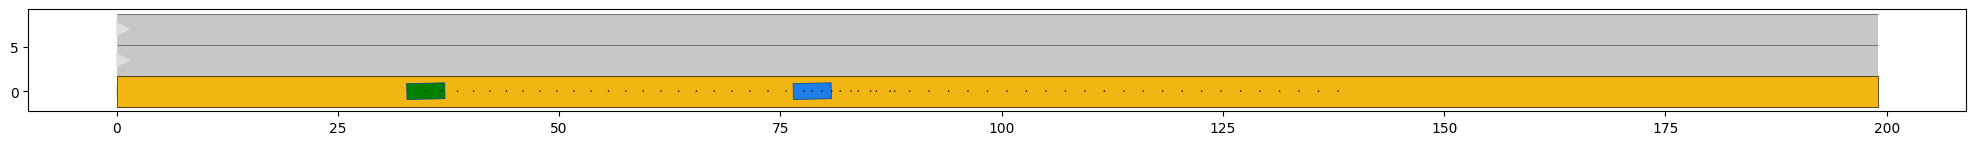

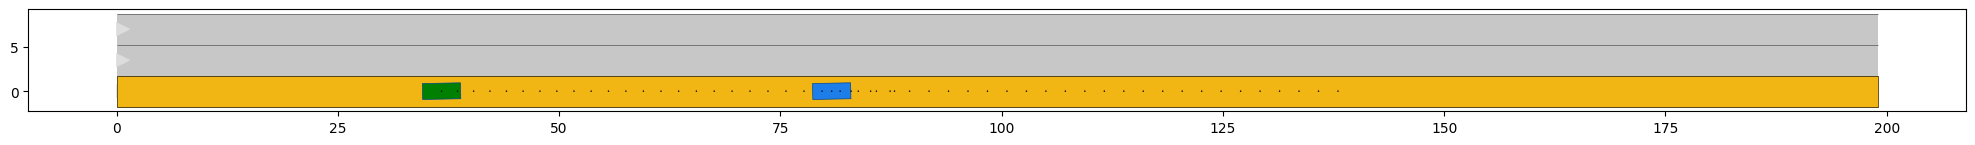

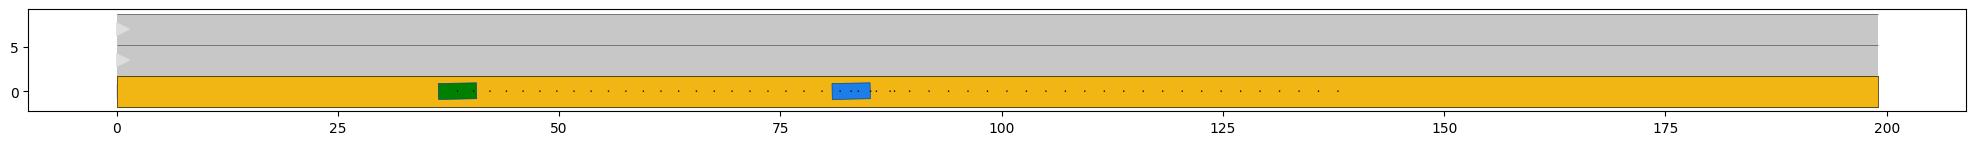

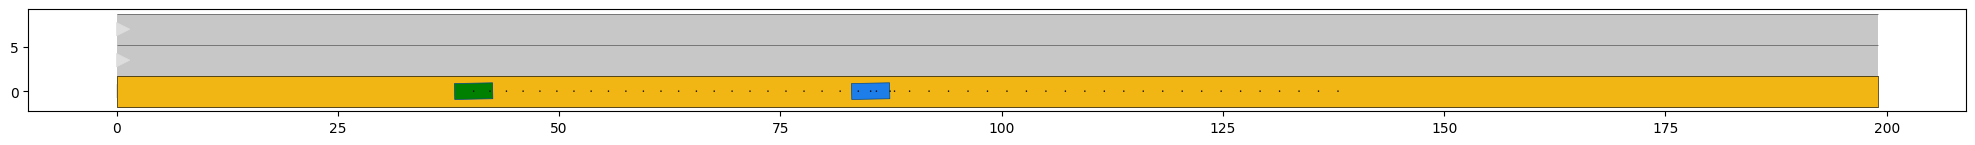

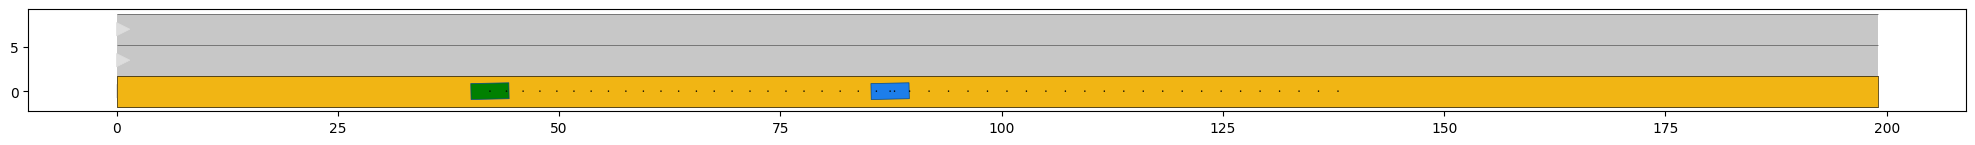

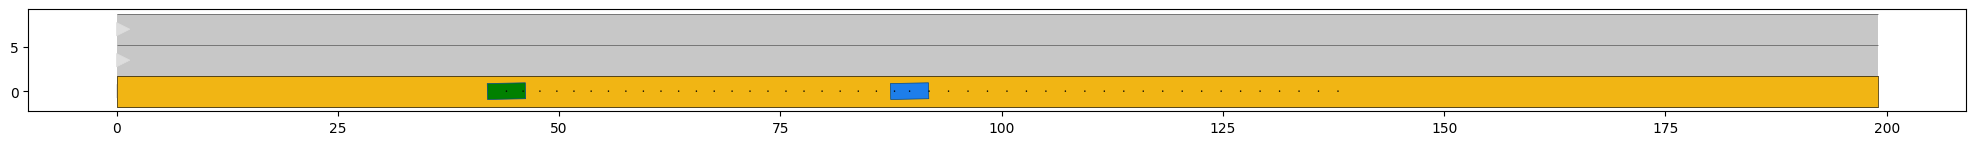

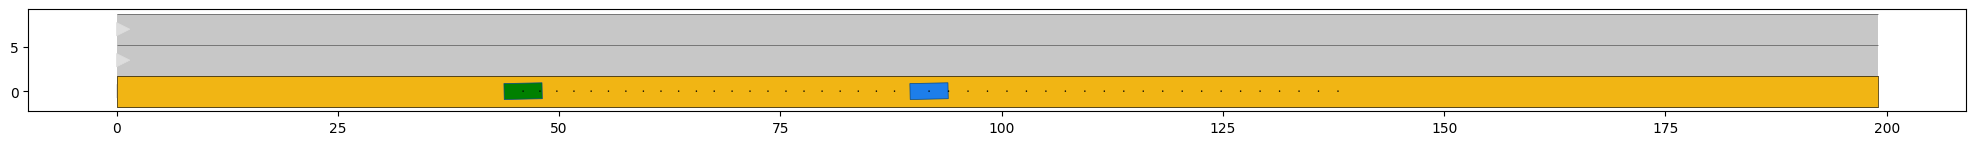

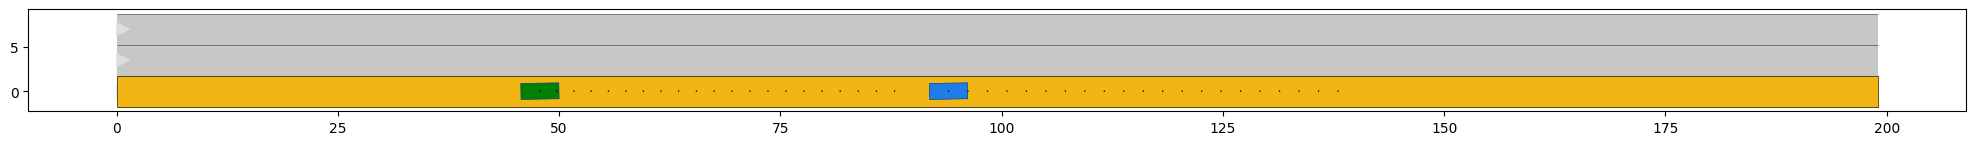

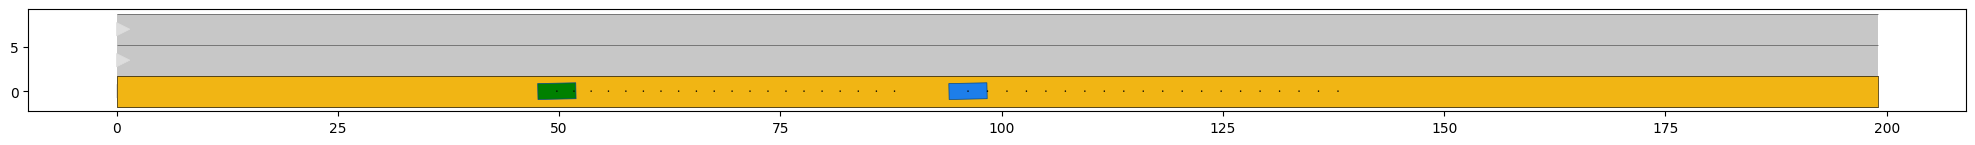

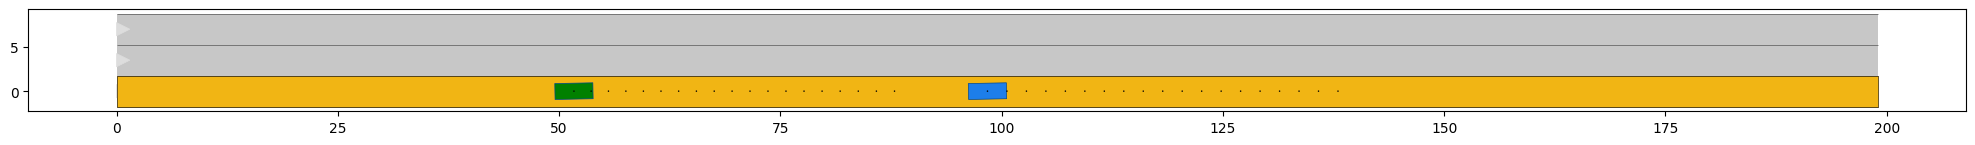

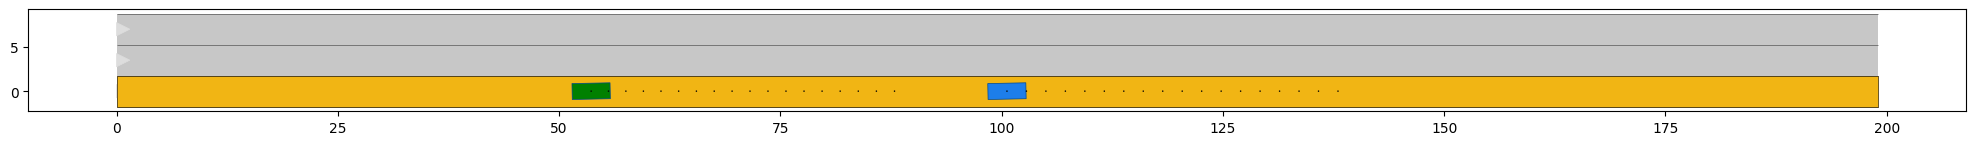

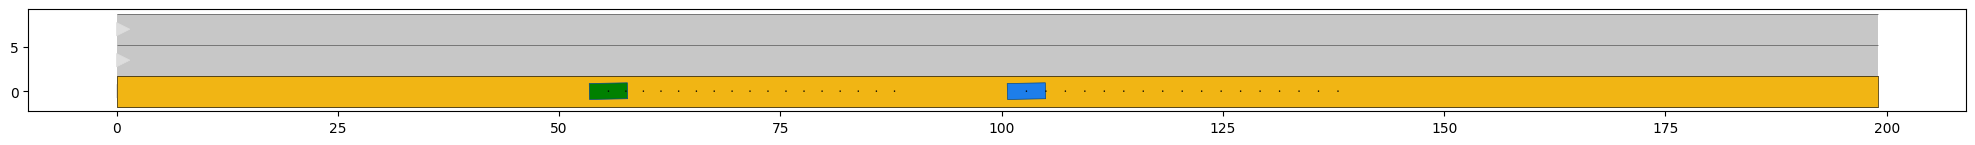

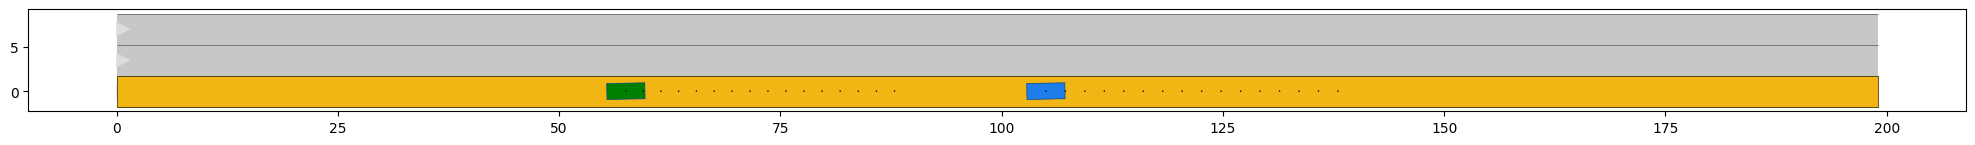

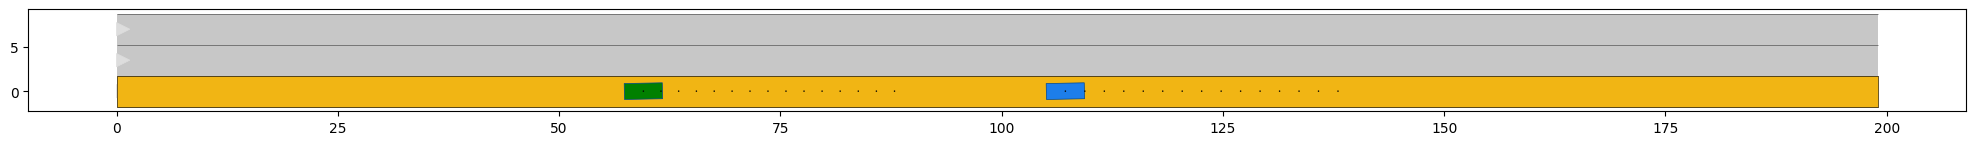

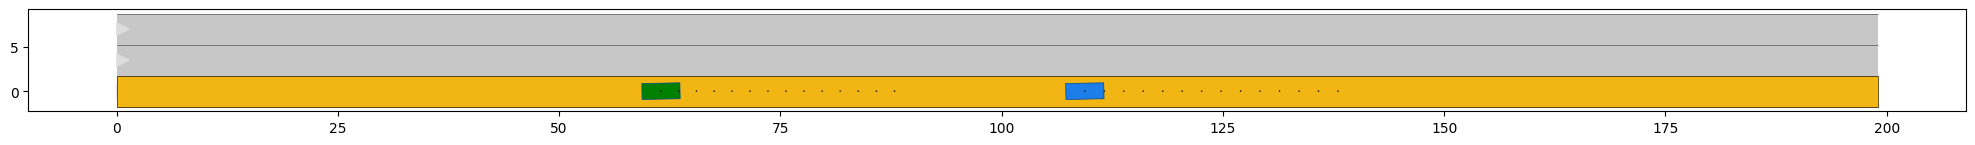

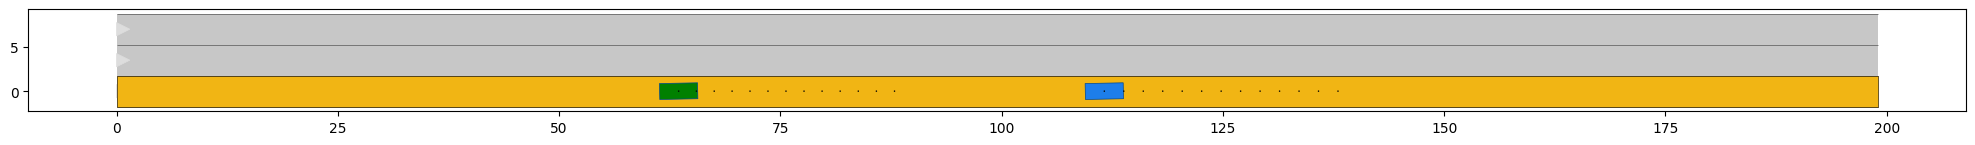

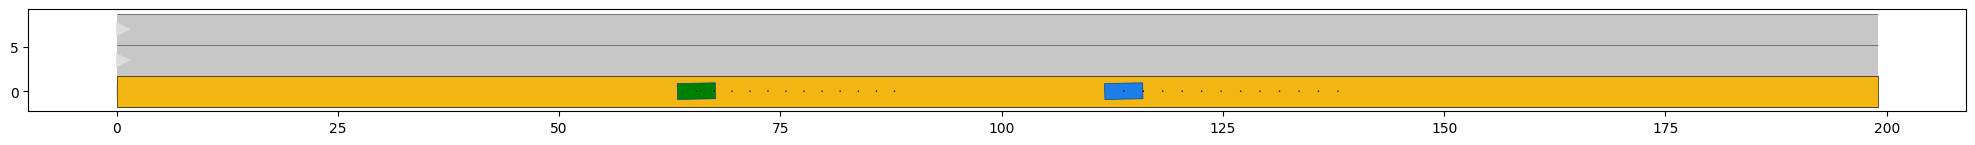

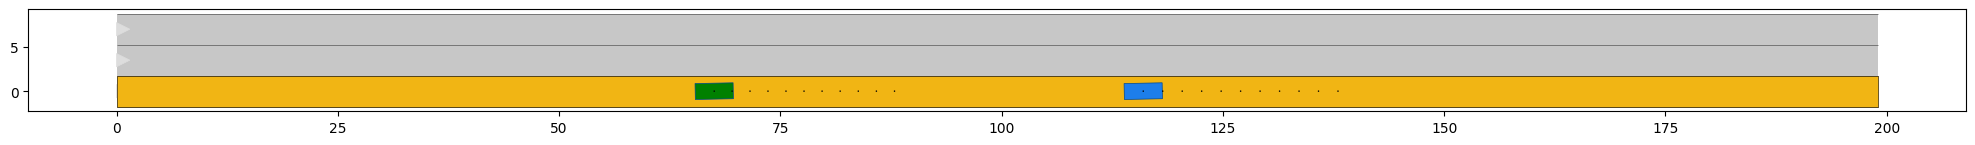

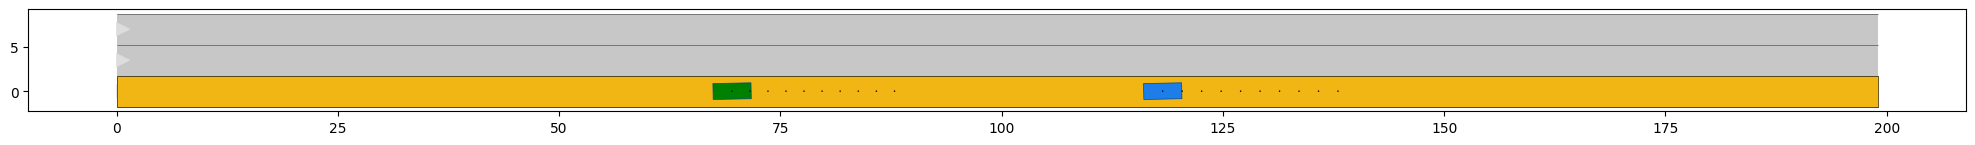

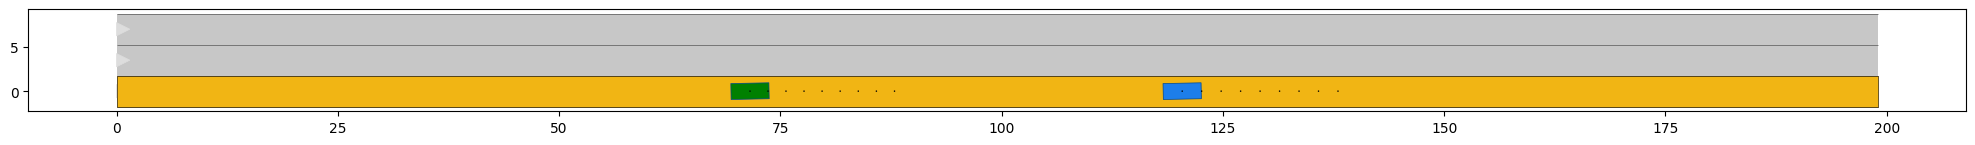

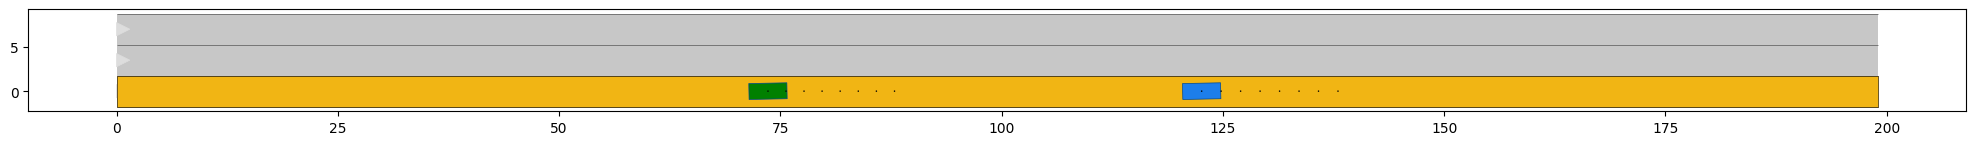

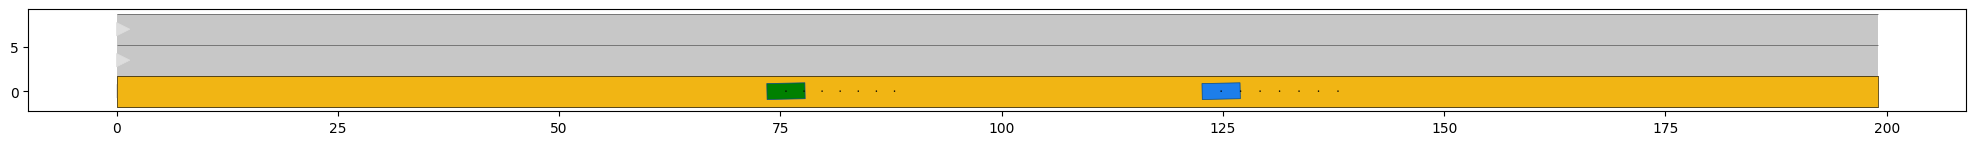

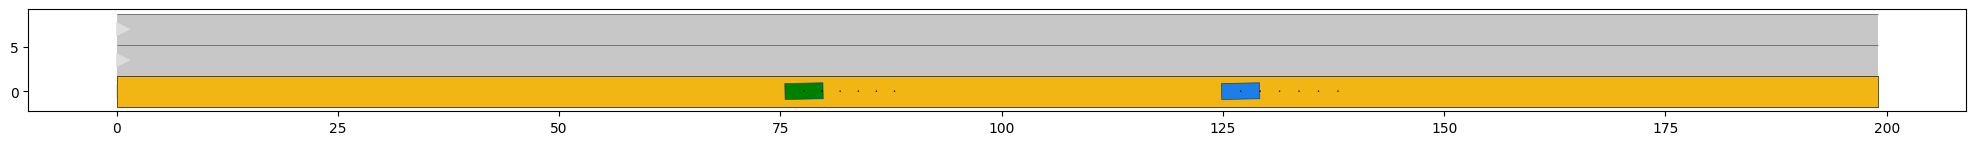

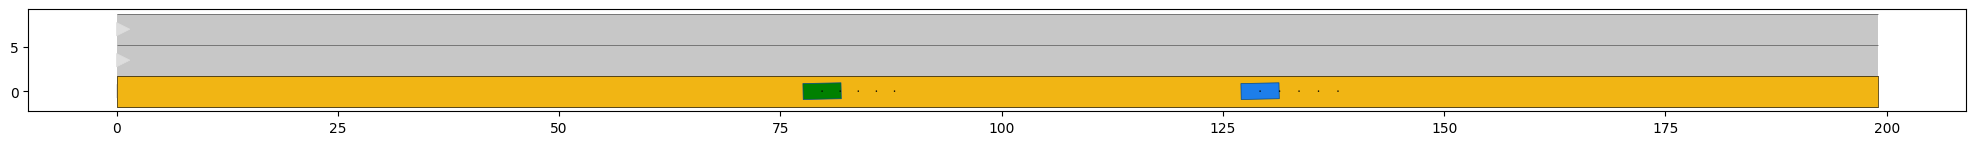

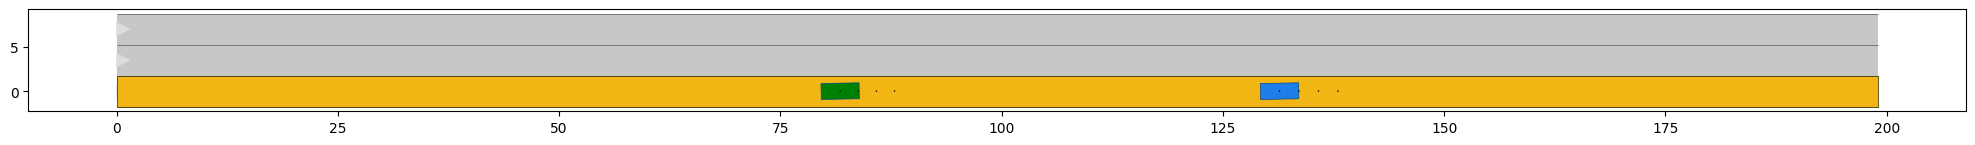

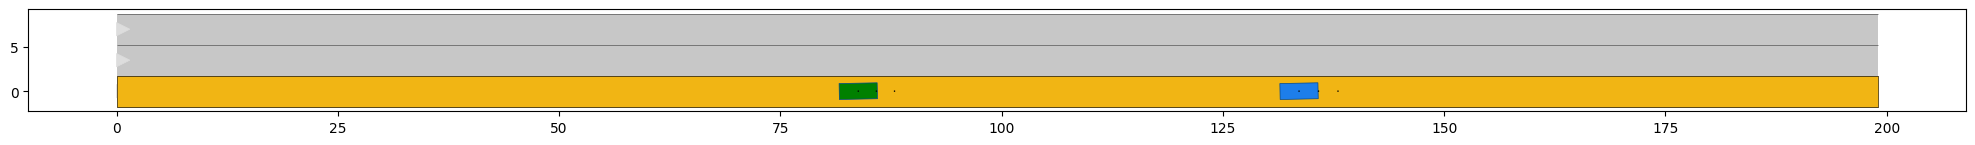

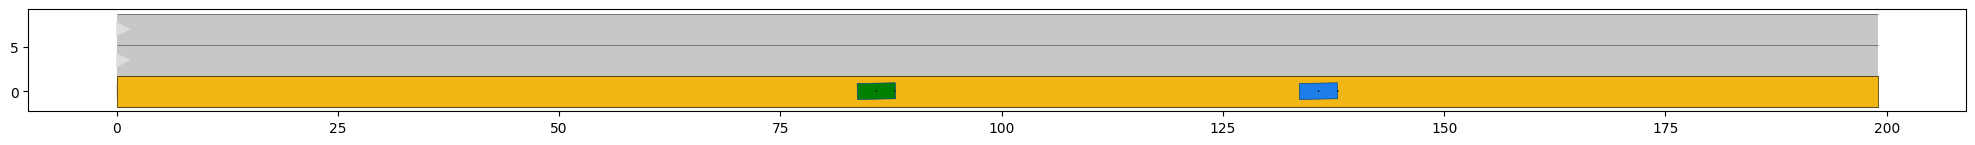

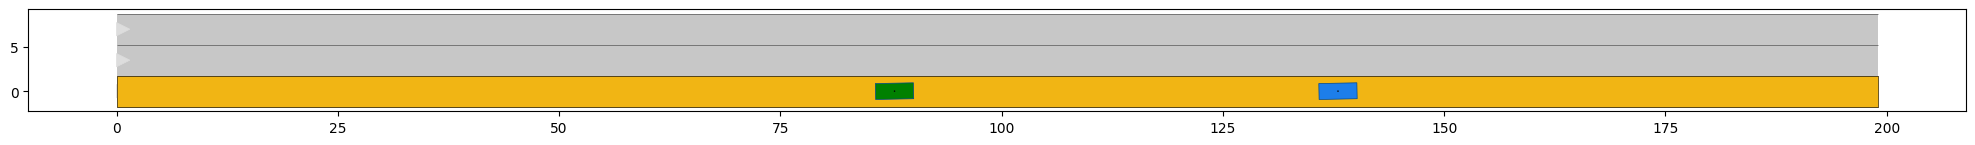

In [ ]:
# import necessary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import ObstacleType, DynamicObstacle
from commonroad.scenario.state import InitialState, CustomState
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction

pos = (x.value)[0, :].flatten() - h * (x.value)[1, :].flatten()
vel = (x.value)[1, :].flatten()

# initial state has a time step of 0
dynamic_obstacle_initial_state = CustomState(
    position=np.array([pos[0], 0]),
    velocity=vel[0],
    orientation=0.02,
    time_step=0).convert_state_to_state(InitialState())

# generate the states for the obstacle for time steps 1 to 40 by assuming constant velocity

state_list = [
    CustomState(position=np.array([pos[i], 0]),
                velocity=vel[i],
                orientation=0.02,
                time_step=i) for i in range(1, N + 1)
]
print(state_list)

# create the trajectory of the obstacle, starting at time step 1
dynamic_obstacle_trajectory = Trajectory(1, state_list)

# create the prediction using the trajectory and the shape of the obstacle
dynamic_obstacle_shape = Rectangle(width=1.8, length=4.3)
dynamic_obstacle_prediction = TrajectoryPrediction(dynamic_obstacle_trajectory,
                                                   dynamic_obstacle_shape)

# generate the dynamic obstacle according to the specification
dynamic_obstacle_id = scenario.generate_object_id()
dynamic_obstacle_type = ObstacleType.CAR
dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id, dynamic_obstacle_type,
                                   dynamic_obstacle_shape,
                                   dynamic_obstacle_initial_state,
                                   dynamic_obstacle_prediction)
ego_vehicle = dynamic_obstacle
# # add dynamic obstacle to the scenario
# scenario.add_objects(dynamic_obstacle)

# plot the scenario and the ego vehicle for each time step
ego_params = DynamicObstacleParams()
ego_params.vehicle_shape.occupancy.shape.facecolor = "g"
for i in range(0, N + 1):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    scenario.draw(rnd)
    ego_params.time_begin = i
    ego_vehicle.draw(rnd, draw_params=ego_params)
    planning_problem_set.draw(rnd)
    rnd.render()

# # plot the scenario for each time step
# for i in range(0, 41):
#     plt.figure(figsize=(25, 10))
#     rnd = MPRenderer()
#     rnd.draw_params.time_begin = i
#     scenario.draw(rnd)
#     planning_problem_set.draw(rnd)
#     rnd.render()

Simple Scenario where only two vehicles are involved:

In [54]:
x_pre = np.zeros((N + 1, 2))
for i in range(N + 1):
    x_pre[i, 0] = scenario.obstacles[0].state_at_time(i).position[0]
    x_pre[i, 1] = scenario.obstacles[0].state_at_time(i).velocity

# print(x_pre)

AttributeError: 'NoneType' object has no attribute 'position'

In [8]:
initial_position = 15
initial_velocity = 20

x_0 = np.array([initial_position + h * initial_velocity,
                initial_velocity])  # initial state

# Set up optimization problem
cost = 0
# initial state constraint
constr = [x[:, 0] == x_0]

for k in range(N):
    # cost function
    cost += quad_form(x_pre[:, k + 1] - x[:, k + 1], Q) + R * u[k]**2
    # time variant state and input constraints
    constr.append((x_pre[:, k + 1] -
                   x[:, k + 1]) == A @ (x_pre[:, k] - x[:, k]) + B * u[k])

# sums problem objectives and concatenates constraints.
# create optimization problem
prob = Problem(Minimize(cost), constr)

# Solve optimization problem
prob.solve(verbose=True)
# print("Problem is convex: ", prob.is_dcp())
# print("Problem solution is " + prob.status)

plot_state_vector(x, TIConstraints(), x_p=x_pre)

# print(x_pre[0, :])
# print((x.value)[0, :].flatten())
# print((x.value)[1, :].flatten())
# print(x)

ValueError: operands could not be broadcast together with shapes (101,) (2,) 

[CustomState(time_step=1), CustomState(time_step=2), CustomState(time_step=3), CustomState(time_step=4), CustomState(time_step=5), CustomState(time_step=6), CustomState(time_step=7), CustomState(time_step=8), CustomState(time_step=9), CustomState(time_step=10), CustomState(time_step=11), CustomState(time_step=12), CustomState(time_step=13), CustomState(time_step=14), CustomState(time_step=15), CustomState(time_step=16), CustomState(time_step=17), CustomState(time_step=18), CustomState(time_step=19), CustomState(time_step=20), CustomState(time_step=21), CustomState(time_step=22), CustomState(time_step=23), CustomState(time_step=24), CustomState(time_step=25), CustomState(time_step=26), CustomState(time_step=27), CustomState(time_step=28), CustomState(time_step=29), CustomState(time_step=30), CustomState(time_step=31), CustomState(time_step=32), CustomState(time_step=33), CustomState(time_step=34), CustomState(time_step=35), CustomState(time_step=36), CustomState(time_step=37), CustomSta

C:\Users\zhaox\AppData\Local\Temp\ipykernel_19540\1819390301.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(25, 10))


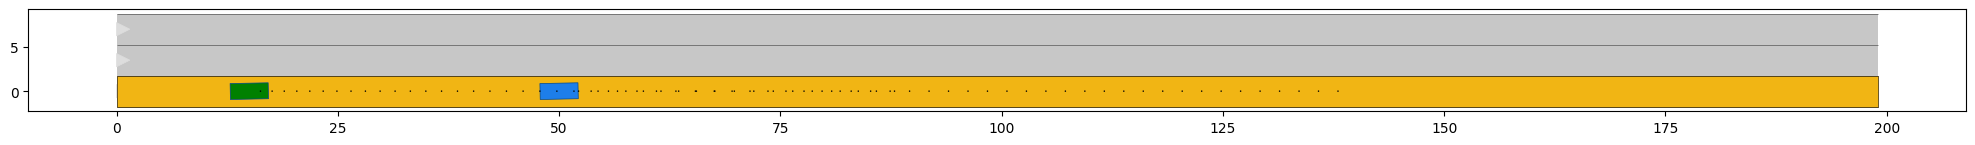

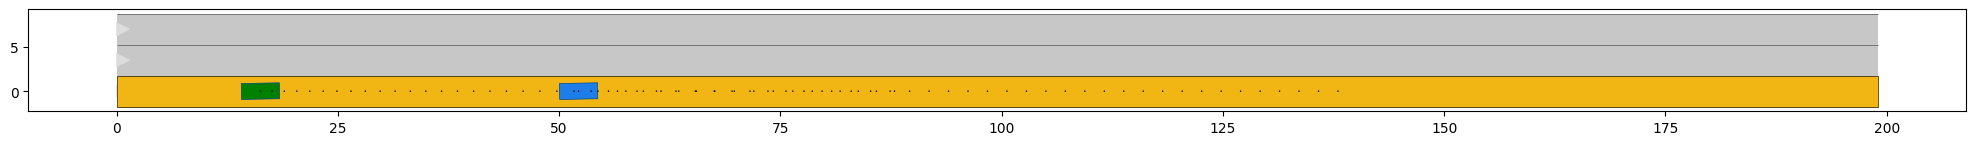

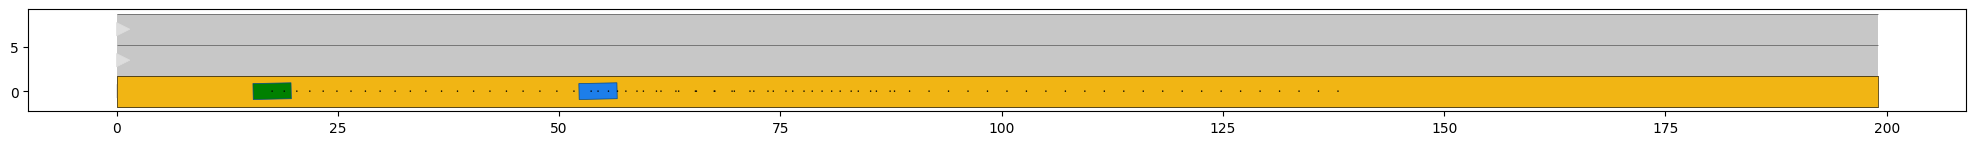

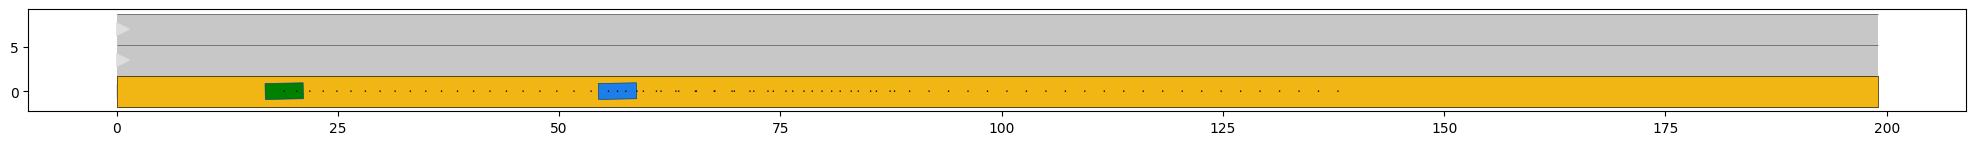

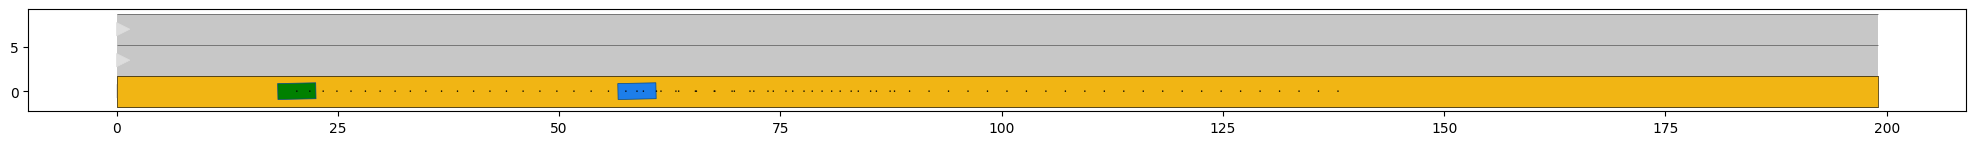

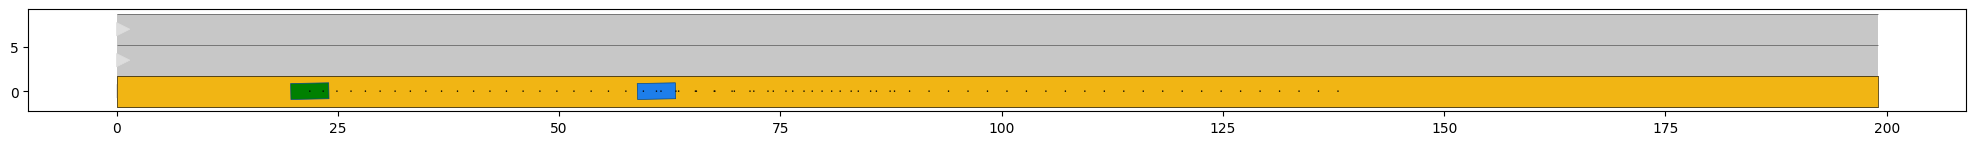

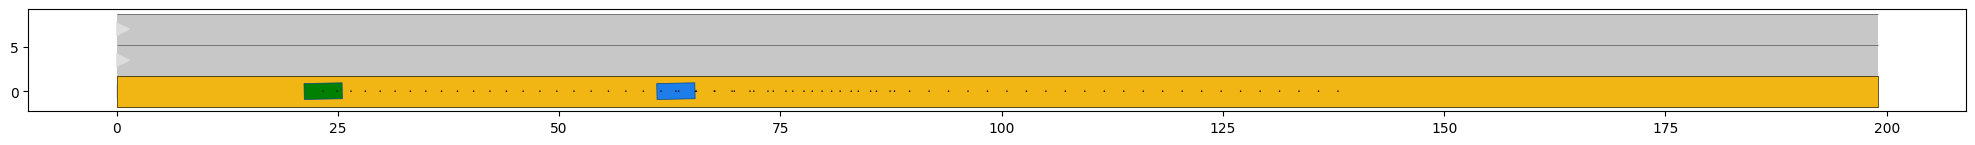

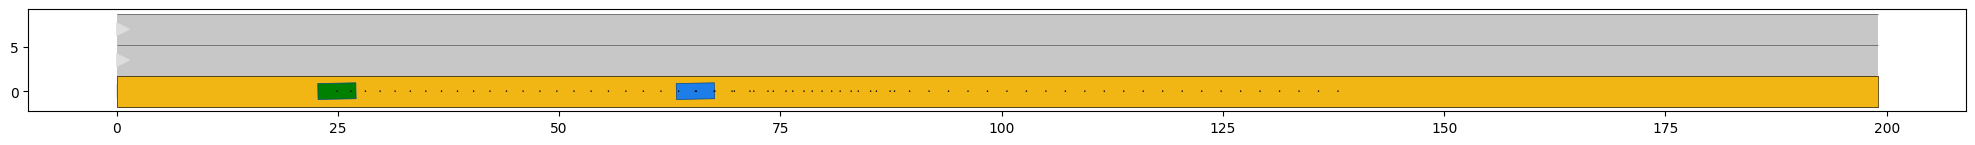

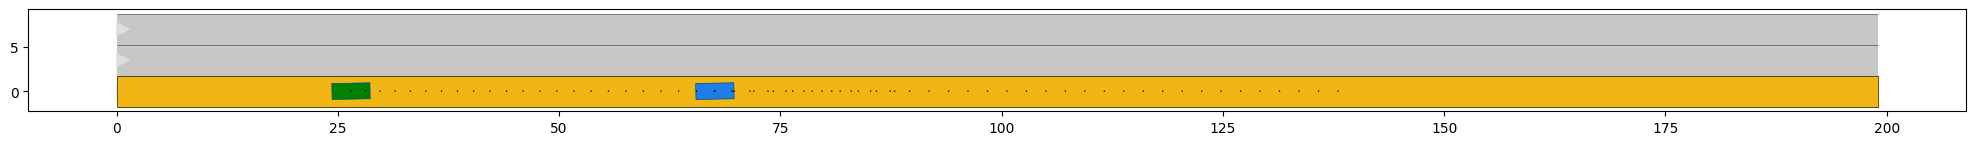

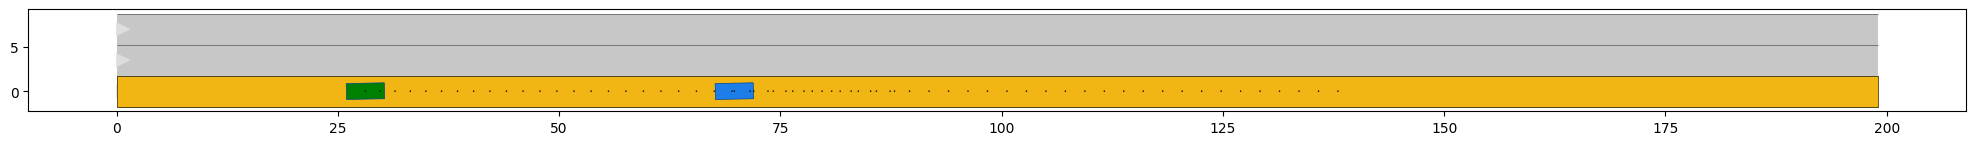

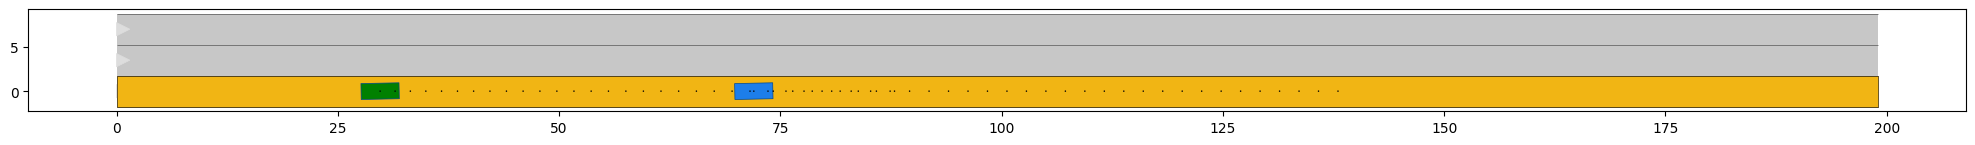

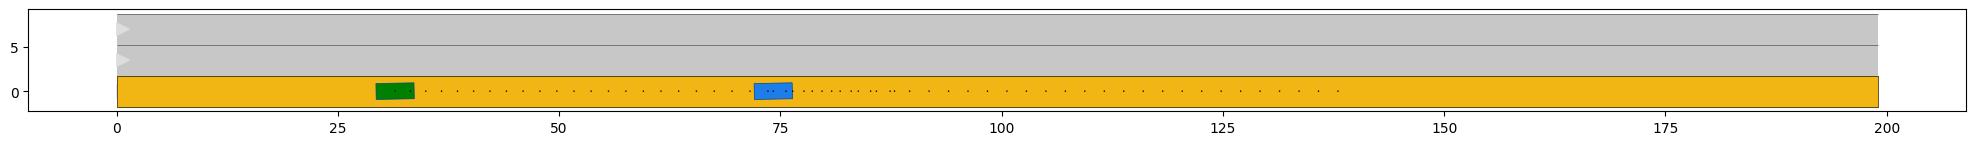

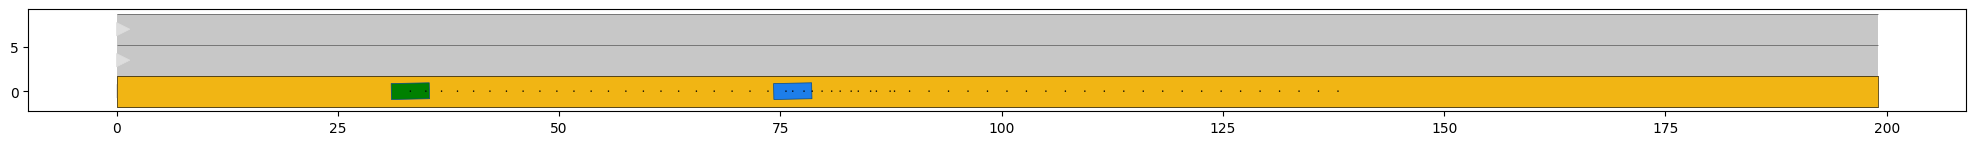

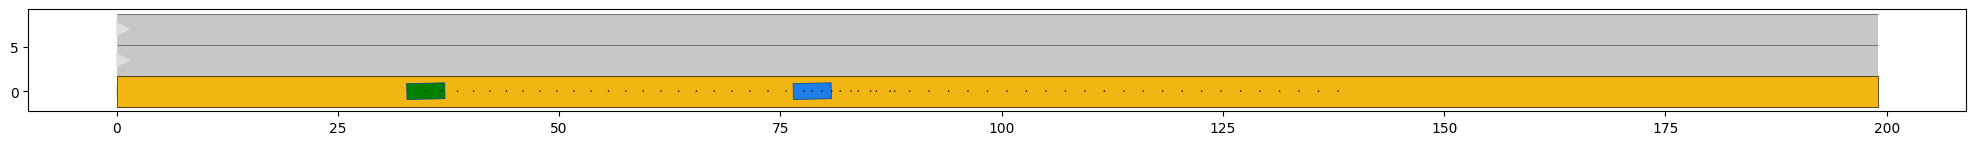

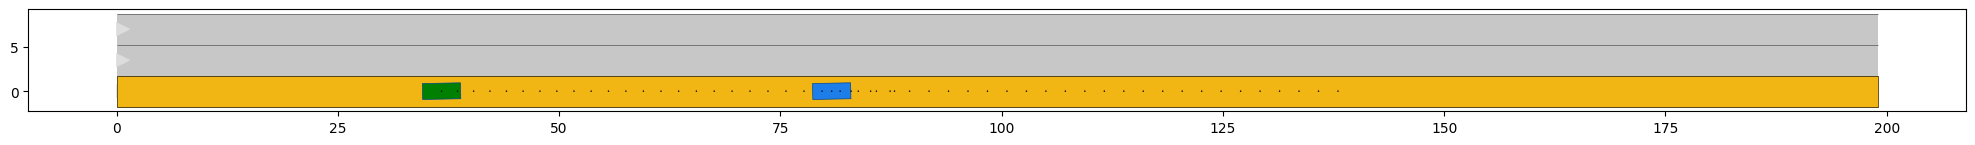

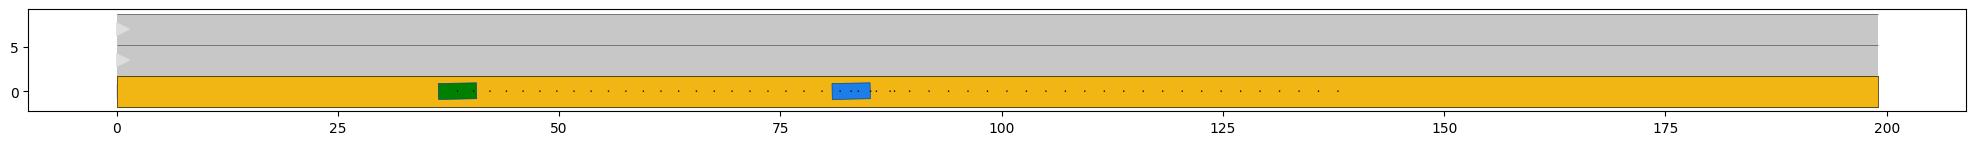

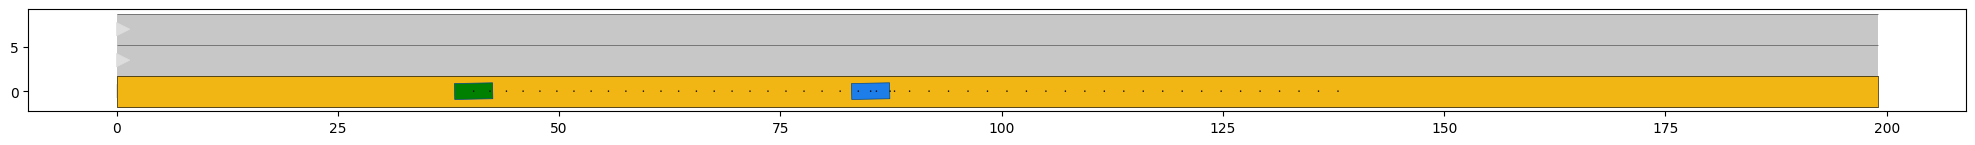

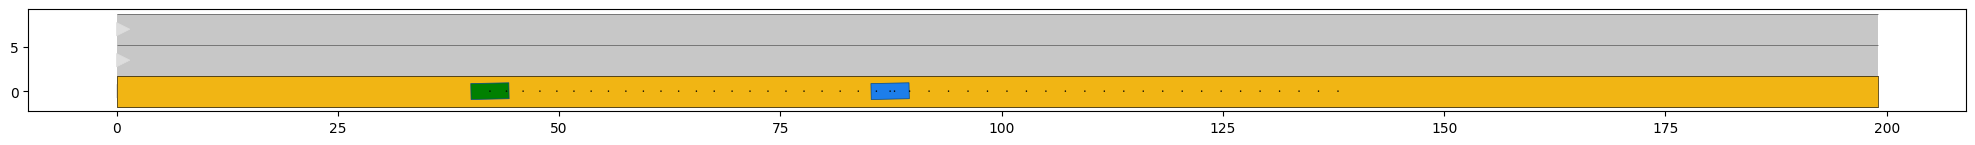

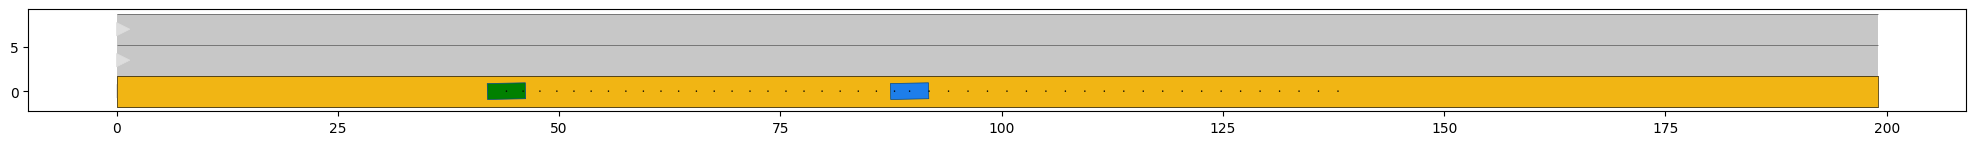

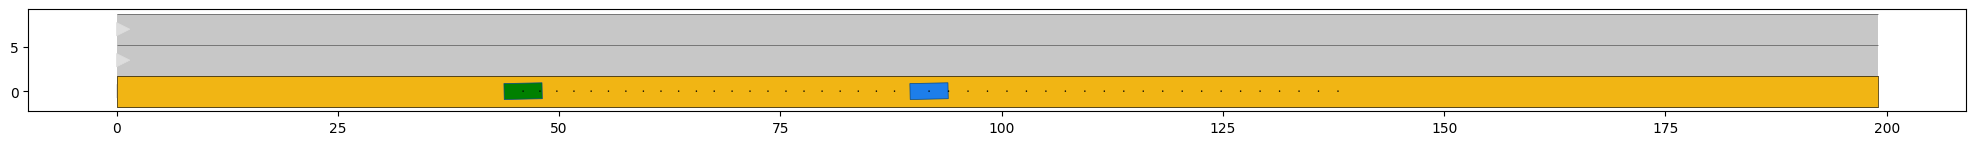

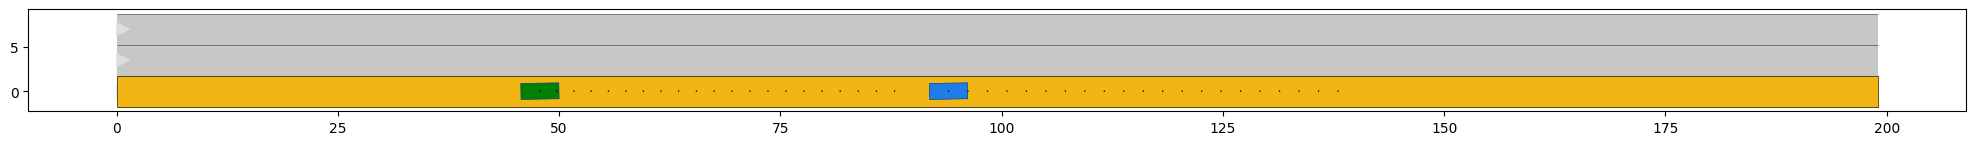

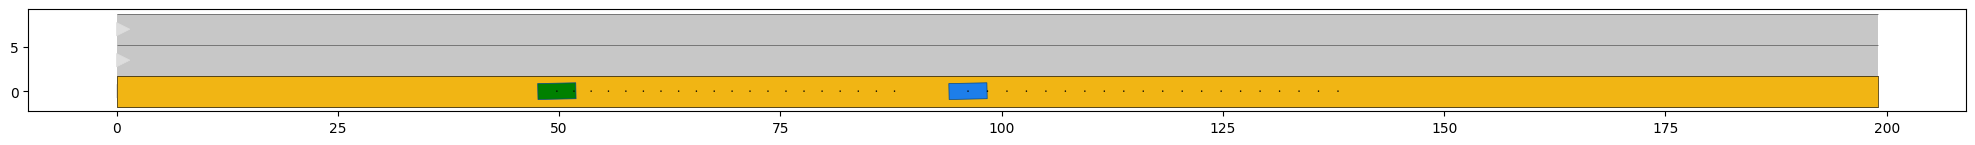

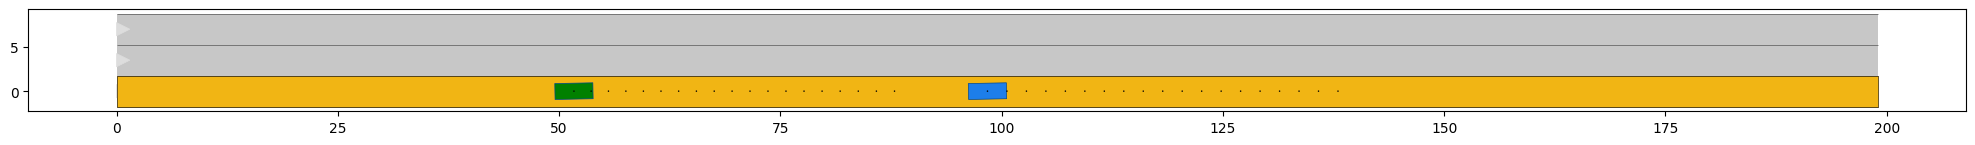

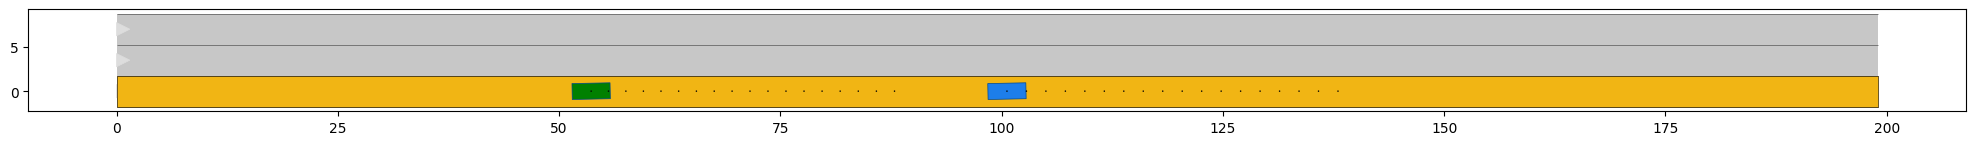

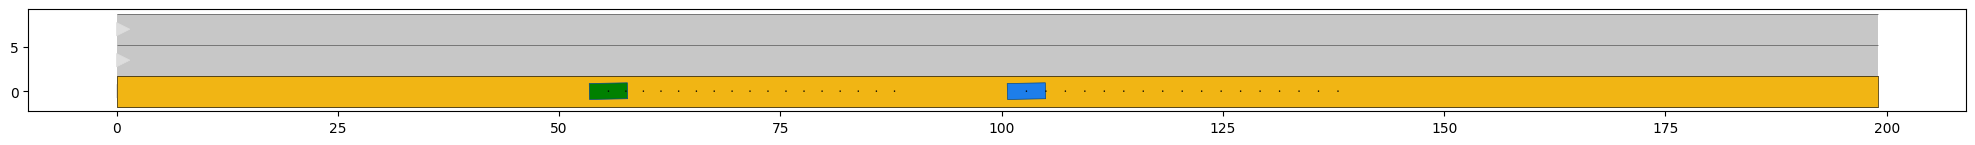

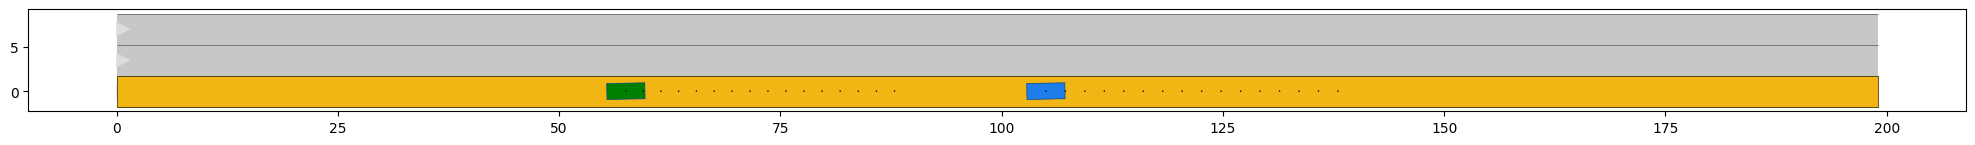

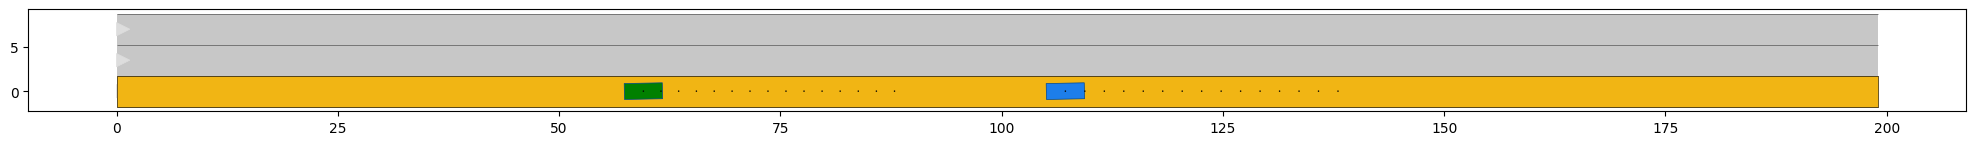

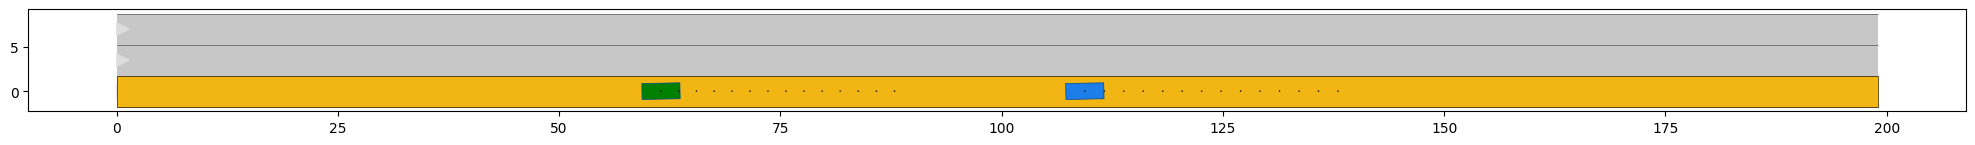

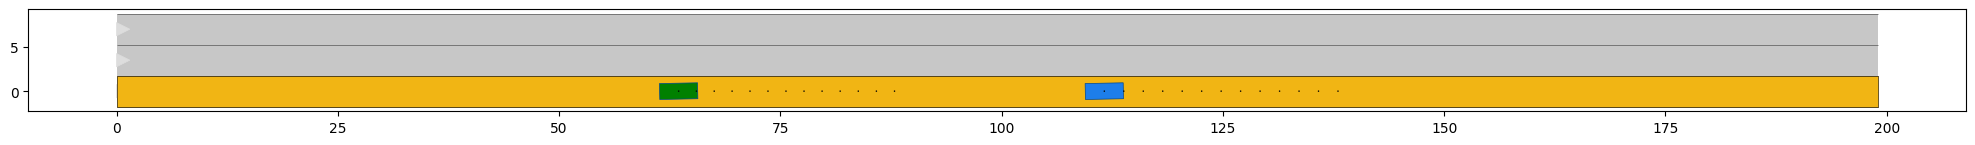

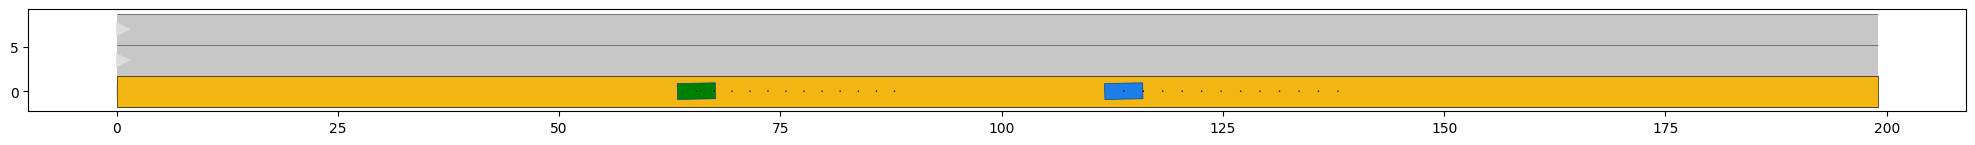

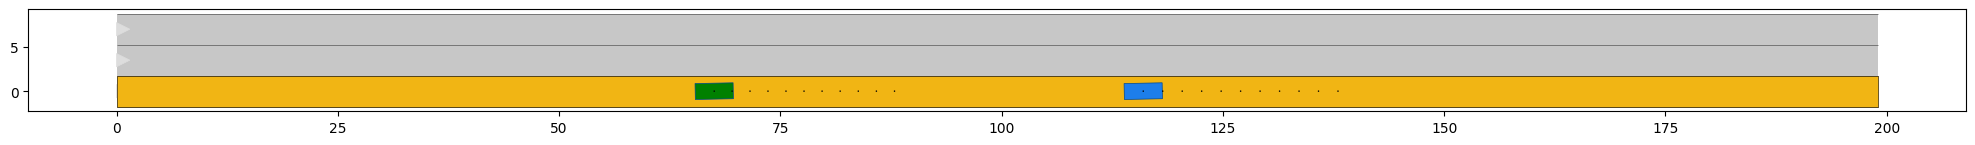

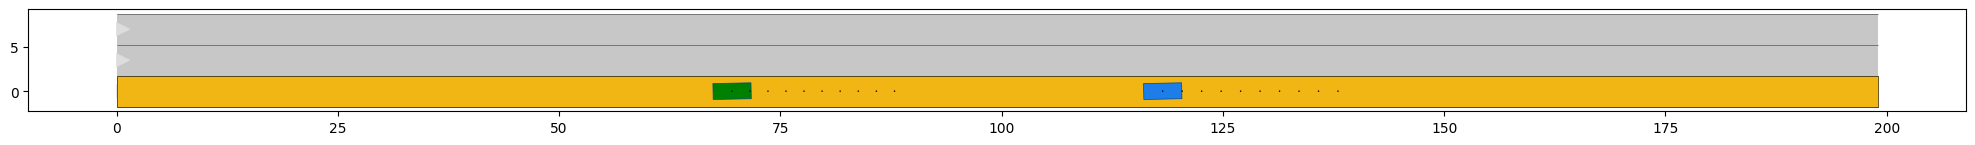

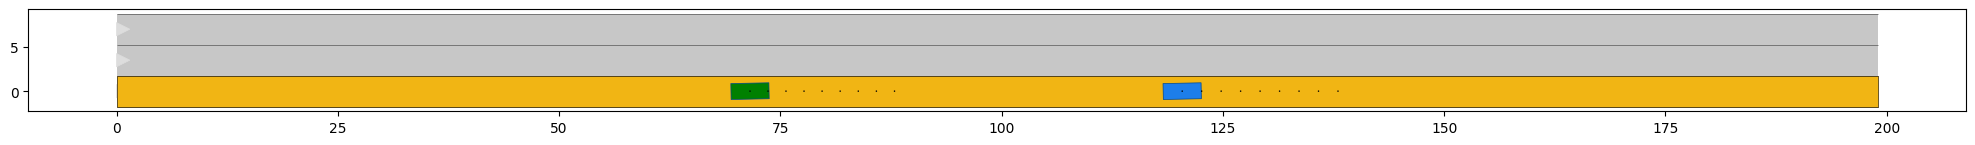

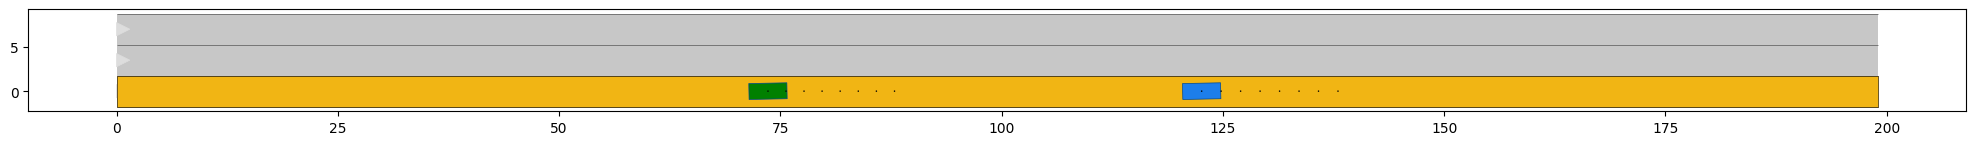

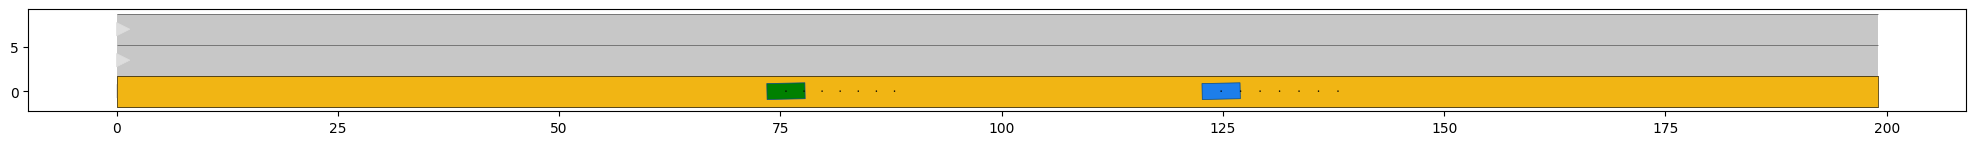

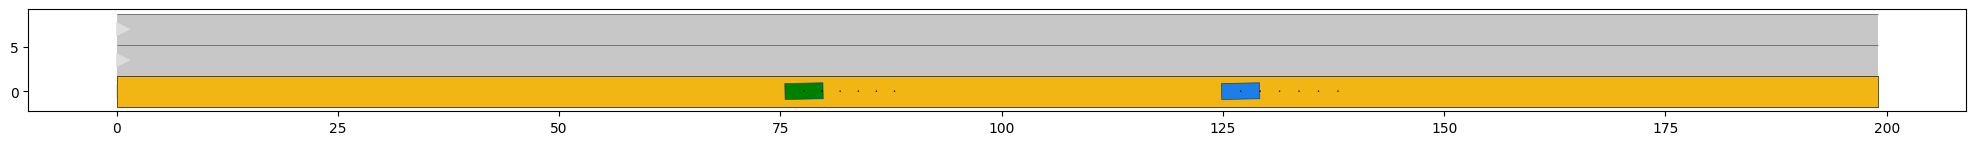

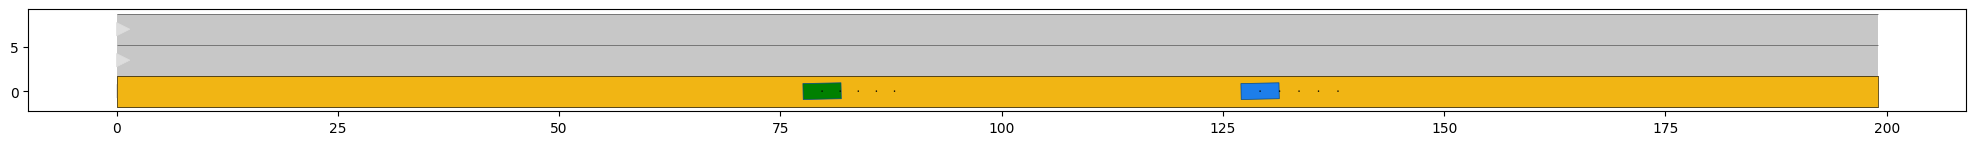

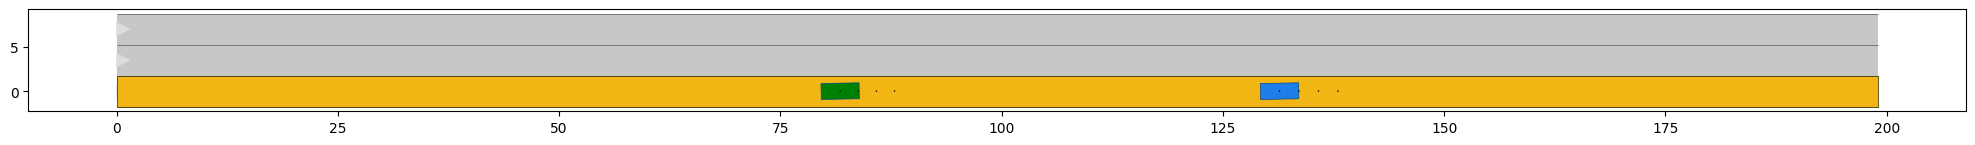

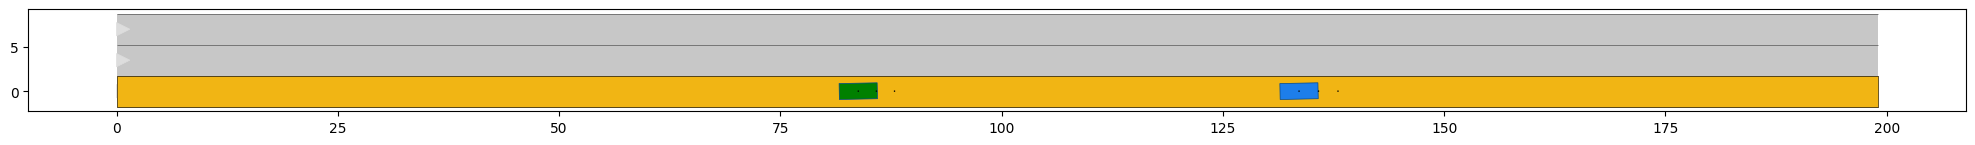

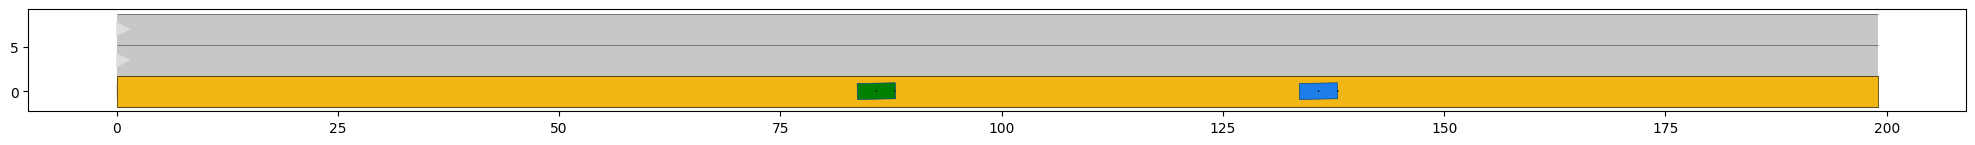

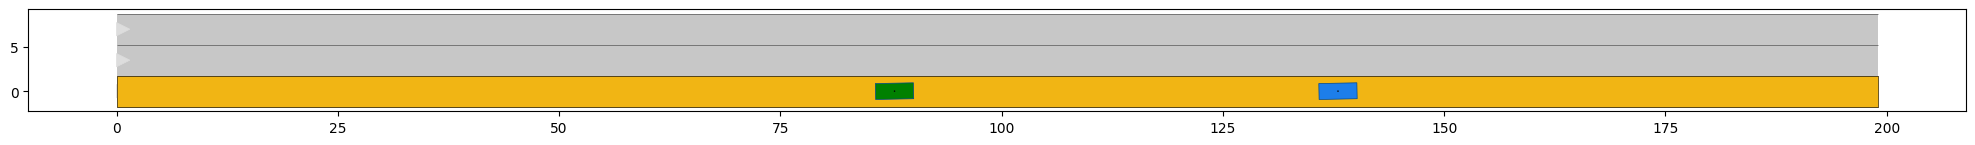

In [ ]:
import numpy as np
# import necessary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import ObstacleType, DynamicObstacle
from commonroad.scenario.state import InitialState, CustomState
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction

pos = (x.value)[0, :].flatten() - h * (x.value)[1, :].flatten()
vel = (x.value)[1, :].flatten()

# initial state has a time step of 0
dynamic_obstacle_initial_state = CustomState(
    position=np.array([pos[0], 0]),
    velocity=vel[0],
    orientation=0.02,
    time_step=0).convert_state_to_state(InitialState())

# generate the states for the obstacle for time steps 1 to 40 by assuming constant velocity

state_list = [
    CustomState(position=np.array([pos[i], 0]),
                velocity=vel[i],
                orientation=0.02,
                time_step=i) for i in range(1, N + 1)
]
print(state_list)

# create the trajectory of the obstacle, starting at time step 1
dynamic_obstacle_trajectory = Trajectory(1, state_list)

# create the prediction using the trajectory and the shape of the obstacle
dynamic_obstacle_shape = Rectangle(width=1.8, length=4.3)
dynamic_obstacle_prediction = TrajectoryPrediction(dynamic_obstacle_trajectory,
                                                   dynamic_obstacle_shape)

# generate the dynamic obstacle according to the specification
dynamic_obstacle_id = scenario.generate_object_id()
dynamic_obstacle_type = ObstacleType.CAR
dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id, dynamic_obstacle_type,
                                   dynamic_obstacle_shape,
                                   dynamic_obstacle_initial_state,
                                   dynamic_obstacle_prediction)
ego_vehicle = dynamic_obstacle
# # add dynamic obstacle to the scenario
# scenario.add_objects(dynamic_obstacle)

# plot the scenario and the ego vehicle for each time step
ego_params = DynamicObstacleParams()
ego_params.vehicle_shape.occupancy.shape.facecolor = "g"
for i in range(0, N + 1):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    scenario.draw(rnd)
    ego_params.time_begin = i
    ego_vehicle.draw(rnd, draw_params=ego_params)
    planning_problem_set.draw(rnd)
    rnd.render()

# # plot the scenario for each time step
# for i in range(0, 41):
#     plt.figure(figsize=(25, 10))
#     rnd = MPRenderer()
#     rnd.draw_params.time_begin = i
#     scenario.draw(rnd)
#     planning_problem_set.draw(rnd)
#     rnd.render()